# Exploratory Analysis
This notebook contains code for analyzing every feature individually (univariate analysis) and also multiple features (multivariate analysis).

Decisions for preprocessing are documented here and performed in data_preprocessing.ipynb.

## 0. Data Loading and Libraries

In [406]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

In [407]:
# Loading data
df_train = pd.read_csv("../../data/train_data.csv")
df_test = pd.read_csv("../../data/test_data.csv")

<ipython-input-407-d68ed3152127>:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/content/train_data.csv")


## Helper functions

In [408]:
def convert_dates(df, date_columns):
    """Convert specified columns to datetime."""
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [409]:
def basic_descriptive_stats(df):
    """Display basic descriptive statistics for a DataFrame."""
    print("First 5 rows:")
    display(df.head())
    print("\nData Info:")
    display(df.info())
    print("\nNumerical Features Description:")
    display(df.describe())
    print("\nCategorical Features Description:")
    display(df.describe(include=['object', 'category']))
    print("\nMissing Values Summary:")
    print(df.isna().sum())
    print("\nDuplicate Check:")
    print(f"Number of duplicates: {df.duplicated().sum()}")


In [410]:
def feature_splitting(df, threshold=25):
    """Splits the DataFrame columns into date, categorical, high cardinality categorical, and numerical features."""
    date_features = [col for col in df.columns if 'Date' in col]
    non_metric_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    non_metric_high_cardinality = [col for col in non_metric_features if df[col].nunique() > threshold]
    metric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    print("Non-metric (Categorical) features:", non_metric_features)
    print("Non-metric (High Cardinality) features:", non_metric_high_cardinality)
    print("Metric (Numerical) features:", metric_features)

    return date_features, non_metric_features, non_metric_high_cardinality, metric_features

# Use for both train and test sets
date_features, non_metric_features, non_metric_high_cardinality, metric_features = feature_splitting(df_train)


Non-metric (Categorical) features: ['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']
Non-metric (High Cardinality) features: ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'County of Injury', 'First Hearing Date', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code']
Metric (Numerical) features: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'Industry Code', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Pa

In [411]:
def check_missing_patterns(df, columns_to_check):
    """Checks if certain variables have all their missing values in the same rows."""
    for col in columns_to_check:
        missing_rows = df[df[col].isna()][columns_to_check]
        display(missing_rows.info())


In [412]:
def num_dist(df, metric_features, bins=30):
    """Display histograms of numerical features."""
    df[metric_features].hist(bins=bins, figsize=(15, 10))
    plt.suptitle("Distribution of Numerical Variables")
    plt.show()


In [413]:
def cat_counts_and_plots(df, excl_feat=[]):
    """Display value counts and plots for categorical features, excluding high cardinality features if needed."""
    for column in df.select_dtypes(include='object').columns:
        if column not in excl_feat:
            print(f"Value counts for {column}:")
            print(df[column].value_counts())
            print("\n")

            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=column, order=df[column].value_counts().index)
            plt.title(f"Count of {column}")
            plt.xticks(rotation=90)
            plt.show()


In [414]:
def plot_bar(df, col, degrees=0):
    """Plot a bar chart for a specified column."""
    column = df[col].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column.index.astype(str), y=column.values)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=degrees)
    plt.show()

def plot_hist(df, col, rotate=False):
    """Plot a histogram for a specified column with KDE."""
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    if rotate:
        plt.xticks(rotation=45)
    plt.show()

def plot_box(df, col):
    """Plot a boxplot for a specified column."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.xlabel(col)
    plt.show()

def plot_pie(df, col):
    """Plot a pie chart for a specified column with percentage thresholds."""
    value_counts = df[col].value_counts()
    total = value_counts.sum()
    percentages = (value_counts / total) * 100

    above_threshold = percentages[percentages >= 2]
    below_threshold = percentages[percentages < 2]

    if len(below_threshold) > 0:
        other_percentage = below_threshold.sum()
        above_threshold['Others'] = other_percentage

    plt.figure(figsize=(8, 8))
    above_threshold.plot.pie(autopct='%1.1f%%', startangle=90, labels=above_threshold.index)
    plt.ylabel("")
    plt.xlabel(col)
    plt.legend(title="Legend", loc='upper left')
    plt.show()

def plot_heatmap(df, numerical_features):
    """Display heatmap of correlation among numerical features."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=df[numerical_features].corr(method='spearman'), annot=True, cmap="coolwarm", fmt='.1f')
    plt.show()


In [415]:
def detect_outliers_in_column(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [416]:
# NEW
def cast_code_columns(df, code_identifiers=['Code']):
    """
    Cast columns with names containing keywords (e.g., 'Code') to categorical data type, ignoring case.

    Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        code_identifiers (list): List of keywords to identify code columns. Default is ['Code'].

    Returns:
        pd.DataFrame: The modified DataFrame with code columns cast to categorical.
    """
    # Convert code_identifiers to lowercase for case-insensitive matching
    code_identifiers = [keyword.lower() for keyword in code_identifiers]

    # Loop through columns to find those that match code identifiers, case-insensitively
    for col in df.columns:
        if any(keyword in col.lower() for keyword in code_identifiers):
            # Check if the column is currently numeric, then cast to category
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].astype('category')
                print(f"Column '{col}' cast to 'category' data type.")
            else:
                print(f"Column '{col}' already non-numeric, no casting applied.")

    return df

In [417]:
# Define date columns
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
convert_dates(df_train, date_columns)
convert_dates(df_test, date_columns)

In [418]:
df_train = cast_code_columns(df_train)
df_test = cast_code_columns(df_test)

Column 'Industry Code' cast to 'category' data type.
Column 'Industry Code Description' already non-numeric, no casting applied.
Column 'WCIO Cause of Injury Code' cast to 'category' data type.
Column 'WCIO Nature of Injury Code' cast to 'category' data type.
Column 'WCIO Part Of Body Code' cast to 'category' data type.
Column 'Zip Code' already non-numeric, no casting applied.
Column 'Industry Code' cast to 'category' data type.
Column 'Industry Code Description' already non-numeric, no casting applied.
Column 'WCIO Cause of Injury Code' cast to 'category' data type.
Column 'WCIO Nature of Injury Code' cast to 'category' data type.
Column 'WCIO Part Of Body Code' cast to 'category' data type.
Column 'Zip Code' already non-numeric, no casting applied.


## General descr. stats

In [419]:
basic_descriptive_stats(df_train)

First 5 rows:


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaT,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaT,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaT,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaT,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64       
 2   Alternative Dispute Resolution      574026 non-null  object        
 3   Assembly Date                       593471 non-null  datetime64[ns]
 4   Attorney/Representative             574026 non-null  object        
 5   Average Weekly Wage                 545375 non-null  float64       
 6   Birth Year                          544948 non-null  float64       
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 9   Carrier Name                        574026 non-null  object        
 

None


Numerical Features Description:


,Accident Date,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Claim Identifier,First Hearing Date,IME-4 Count,OIICS Nature of Injury Description,Agreement Reached,Number of Dependents
count,570337,574026.000000,593471,5.453750e+05,544948.000000,559466,187245,5.934710e+05,150798,132803.000000,0.0,574026.000000,574026.000000
mean,2021-04-28 21:00:27.892982784,42.114270,2021-07-19 03:25:38.260841728,4.910883e+02,1886.767604,2021-07-16 20:11:19.865443328,2021-07-26 21:31:28.449891840,2.366760e+07,2022-03-19 05:07:38.218278400,3.207337,NaN,0.046665,3.006559
min,1961-09-06 00:00:00,0.000000,2020-01-01 00:00:00,0.000000e+00,0.000000,1996-01-12 00:00:00,1992-11-13 00:00:00,5.393066e+06,2020-01-30 00:00:00,1.000000,NaN,0.000000,0.000000
25%,2020-09-14 00:00:00,31.000000,2020-10-26 00:00:00,0.000000e+00,1965.000000,2020-11-06 00:00:00,2020-10-27 00:00:00,5.593414e+06,2021-06-01 00:00:00,1.000000,NaN,0.000000,1.000000
50%,2021-06-27 00:00:00,42.000000,2021-07-29 00:00:00,0.000000e+00,1977.000000,2021-08-09 00:00:00,2021-07-21 00:00:00,5.791212e+06,2022-03-09 00:00:00,2.000000,NaN,0.000000,3.000000
75%,2022-03-21 00:00:00,54.000000,2022-04-19 00:00:00,8.410000e+02,1989.000000,2022-04-26 00:00:00,2022-04-20 00:00:00,5.991000e+06,2023-01-11 00:00:00,4.000000,NaN,0.000000,5.000000
max,2023-09-29 00:00:00,117.000000,2022-12-31 00:00:00,2.828079e+06,2018.000000,2024-06-01 00:00:00,2024-05-31 00:00:00,9.998917e+08,2024-06-07 00:00:00,73.000000,NaN,1.000000,6.000000
std,NaN,14.256432,NaN,6.092918e+03,414.644423,NaN,NaN,1.079271e+08,NaN,2.832303,NaN,0.210921,2.000801



Categorical Features Description:


,Alternative Dispute Resolution,Attorney/Representative,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,Gender,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,WCB Decision
count,574026,574026,574026,574026,574026,574026,574026,574026,574026,564068.0,564068,574026,558386.0,558386,558369.0,558369,556944.0,556944,545389,574026
unique,3,2,2046,8,8,63,2,8,4,24.0,20,5,77.0,74,56.0,56,57.0,54,10060,1
top,N,N,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,M,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,IV,56.0,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,11236,Not Work Related
freq,571412,392291,111144,285368,291078,60430,546505,270779,335218,114339.0,114339,265981,46610.0,46610,153373.0,153373,51862.0,51862,3302,574026



Missing Values Summary:
Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19445
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region            

## Univariate Analysis

In this chapter, we analyse each feature.

### Acident date variable

Let's examine the key statistics for this variable:

In [420]:
df_train['Accident Date'].describe()

,Accident Date
count,570337
mean,2021-04-28 21:00:27.892982784
min,1961-09-06 00:00:00
25%,2020-09-14 00:00:00
50%,2021-06-27 00:00:00
75%,2022-03-21 00:00:00
max,2023-09-29 00:00:00


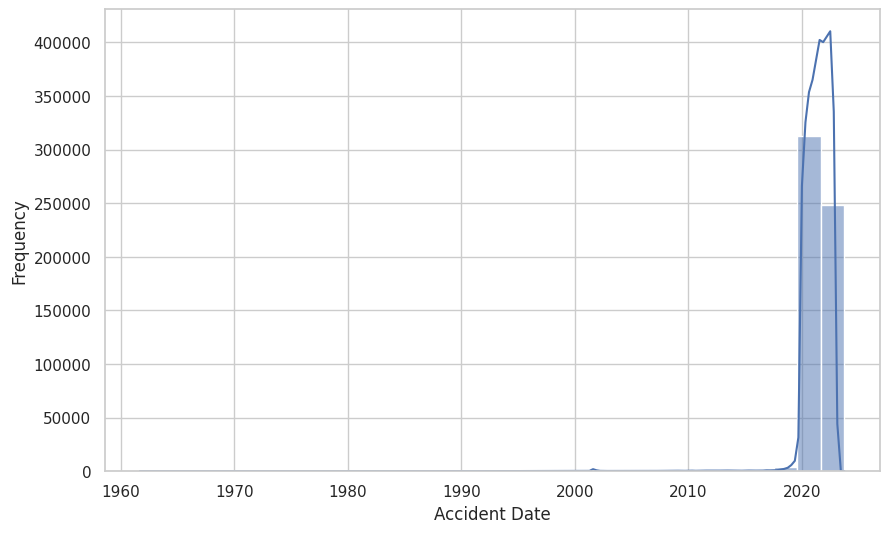

In [421]:
plot_hist(df_train, 'Accident Date')

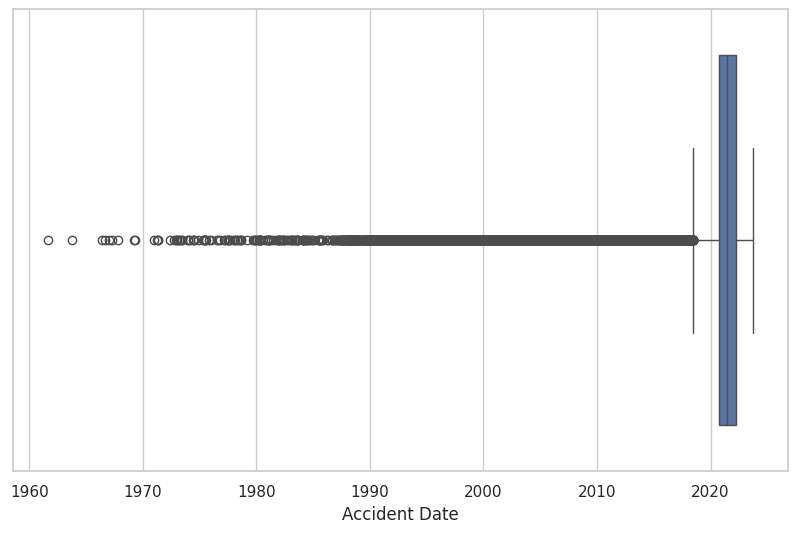

In [422]:
plot_box(df_train, 'Accident Date')

We can see by the histogram, that this variable is very assimetric probably due to having a big number of outliers as we can see in the boxplot. To get better visualisations we will omit this outliers in some visualisations

Now we will analyze the situation regarding the missing values:

In [423]:
print('The Accident Date variable has ' + str(df_train['Accident Date'].isna().mean()*100) + '% of missing values')
print('The Accident Date variable has ' + str(df_test['Accident Date'].isna().mean()*100) + '% of missing values')

The Accident Date variable has 3.898084320885098% of missing values
The Accident Date variable has 0.6299374959726787% of missing values


In [424]:
detect_outliers_in_column(df_train, 'Accident Date')['Accident Date'].max()

Timestamp('2018-06-07 00:00:00')

Let`s extract some adicional date-related columns

In [425]:
df_accident_time=df_train.copy()

In [426]:
df_accident_time['Accident Year'] = df_acident_time['Accident Date'].dt.year
df_accident_time['Accident Month'] = df_acident_time['Accident Date'].dt.month
df_accident_time['Accident DayOfWeek'] = df_acident_time['Accident Date'].dt.dayofweek

This next bar plot show us the number of accidents by day of th week:

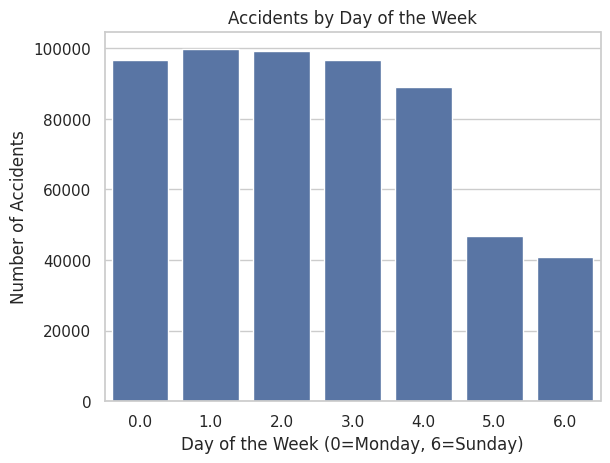

In [427]:
dayofweek_accidents = df_accident_time['Accident DayOfWeek'].value_counts().sort_index()
sns.barplot(x=dayofweek_accidents.index, y=dayofweek_accidents.values)
plt.title("Accidents by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Accidents")
plt.show()

This plot shows that workplace accidents occur more frequently during weekdays, likely because most people work Monday through Friday, resulting in fewer incidents over the weekend when fewer people are on-site

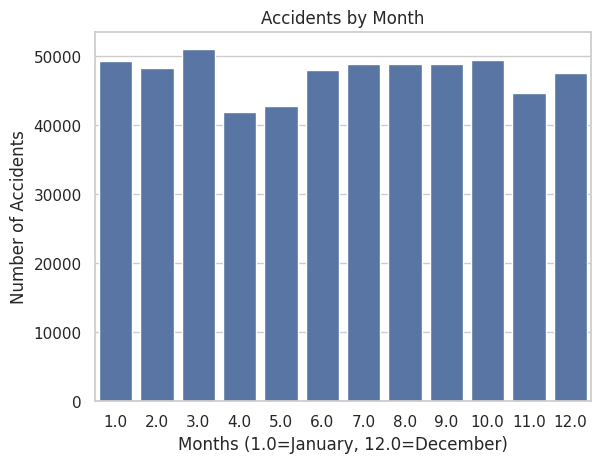

In [428]:
dayofweek_accidents = df_accident_time['Accident Month'].value_counts().sort_index()
sns.barplot(x=dayofweek_accidents.index, y=dayofweek_accidents.values)
plt.title("Accidents by Month")
plt.xlabel("Months (1.0=January, 12.0=December)")
plt.ylabel("Number of Accidents")
plt.show()

From the graph, we notice a decrease in workplace accidents in April and May. What could explain this trend?

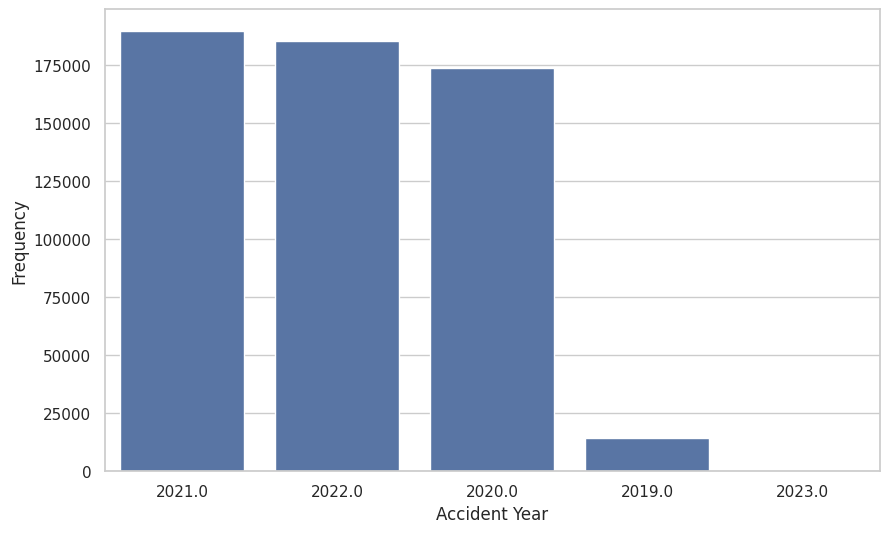

In [429]:
plot_bar(df_accident_time[df_accident_time['Accident Year']>2018], 'Accident Year')

- Observations
  - A lot of outliers (everything before mid 2018).
- Decisions
  - Split date into usable features during a later step.

### Assembly date variable

Let's examine the key statistics for this variable:

In [430]:
df_train['Assembly Date'].describe()

,Assembly Date
count,593471
mean,2021-07-19 03:25:38.260841728
min,2020-01-01 00:00:00
25%,2020-10-26 00:00:00
50%,2021-07-29 00:00:00
75%,2022-04-19 00:00:00
max,2022-12-31 00:00:00


From this table, we see that the first assembly date in this dataframe occurred on 2020-01-01 and the last one on 2022-12-31.

In [431]:
print('The Assembly Date variable has ' + str(df_train['Assembly Date'].isna().mean()*100) + '% of missing values in the train data')
print('The Assembly Date variable has ' + str(df_test['Assembly Date'].isna().mean()*100) + '% of missing values in the test data')

The Assembly Date variable has 0.0% of missing values in the train data
The Assembly Date variable has 0.0% of missing values in the test data


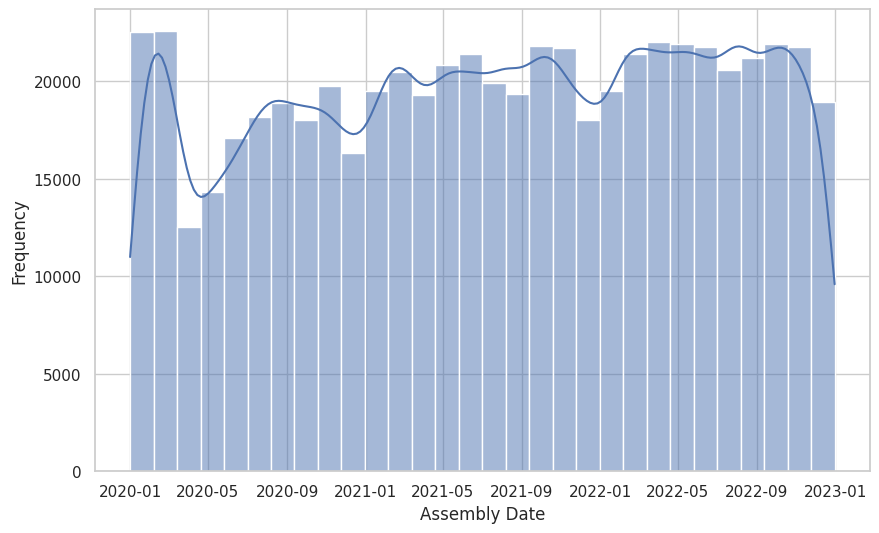

In [432]:
plot_hist(df_train, 'Assembly Date')

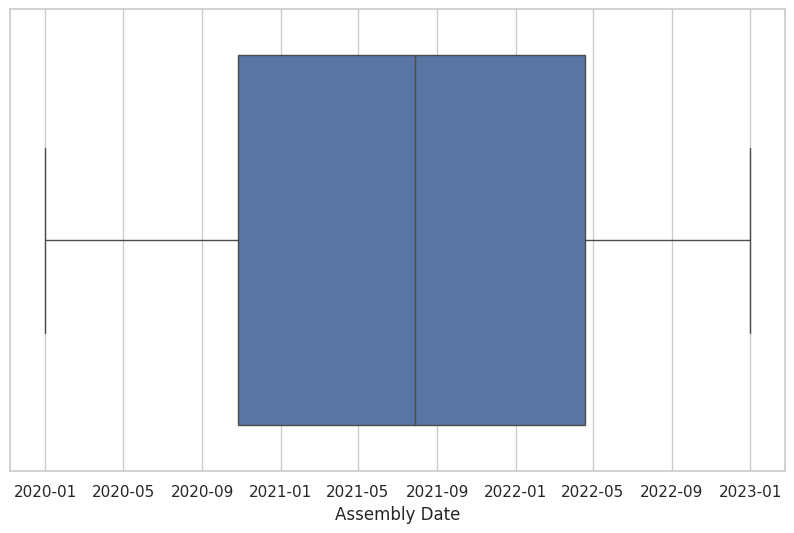

In [433]:
plot_box(df_train, 'Assembly Date')

- Observations
  - No outliers, evenly distributed.
- Decisions
  - Date will be extracted to time since accident date in a later step.

### C-2 Date variable

Let's examine the key statistics for this variable:

In [434]:
df_train['C-2 Date'].describe()

,C-2 Date
count,559466
mean,2021-07-16 20:11:19.865443328
min,1996-01-12 00:00:00
25%,2020-11-06 00:00:00
50%,2021-08-09 00:00:00
75%,2022-04-26 00:00:00
max,2024-06-01 00:00:00


In [435]:
print('The C-2 Date variable has ' + str(df_train['C-2 Date'].isna().mean()*100) + '% of missing values in the train data')
print('The C-2 Date variable has ' + str(df_test['C-2 Date'].isna().mean()*100) + '% of missing values in the test data')

The C-2 Date variable has 5.729850321245689% of missing values in the train data
The C-2 Date variable has 2.3542754043430634% of missing values in the test data


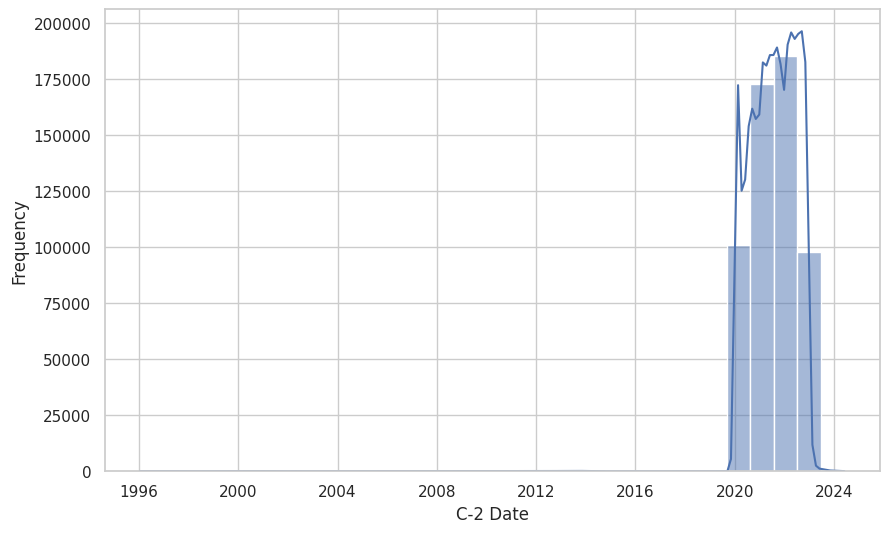

In [436]:
plot_hist(df_train, 'C-2 Date')

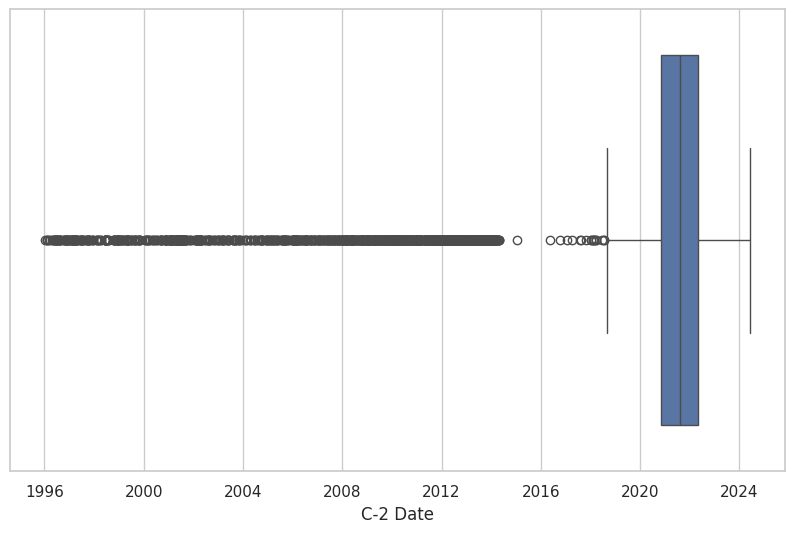

In [437]:
plot_box(df_train, 'C-2 Date')

- Observations
  - Lots of (evenly distributed) outliers.
- Decisions
  - Outliers won't be treated as they seem contain information due to the volume of outliers.

### C-3 Date variable

Let's examine the key statistics for this variable:

In [438]:
df_train['C-3 Date'].describe()

,C-3 Date
count,187245
mean,2021-07-26 21:31:28.449891840
min,1992-11-13 00:00:00
25%,2020-10-27 00:00:00
50%,2021-07-21 00:00:00
75%,2022-04-20 00:00:00
max,2024-05-31 00:00:00


In [439]:
print('The C-3 Date variable has ' + str(df_train['C-3 Date'].isna().mean()*100) + '% of missing values in the train data')
print('The C-3 Date variable has ' + str(df_test['C-3 Date'].isna().mean()*100) + '% of missing values in the test data')

The C-3 Date variable has 68.4491744331231% of missing values in the train data
The C-3 Date variable has 78.0356981764289% of missing values in the test data


This variable is highly composed of missing values, so we will probably exclude her

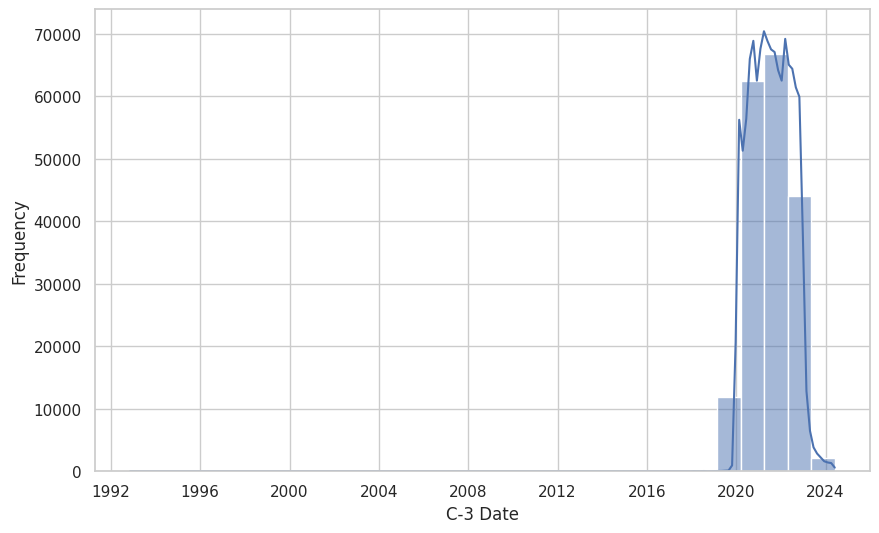

In [440]:
plot_hist(df_train, 'C-3 Date')

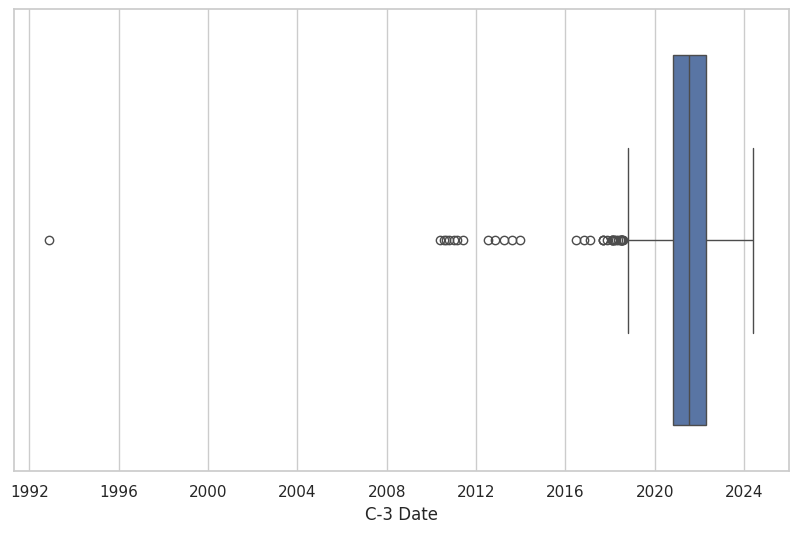

In [441]:
plot_box(df_train, 'C-3 Date')

In [442]:
lower_bound = pd.to_datetime('2018-01-01 00:00:00')
upper_bound = pd.to_datetime('2025-01-01 00:00:00')

df_train['C-3 Date'] = df_train['C-3 Date'].apply(lambda x: min(max(x, lower_bound), upper_bound))

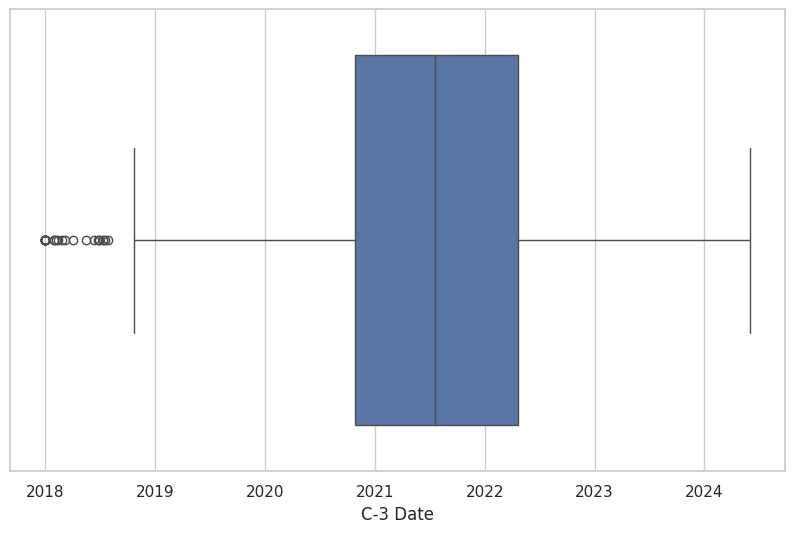

In [443]:
plot_box(df_train, 'C-3 Date')

- Observations
  - Some outliers, one extreme outlier.
- Decisions
  - Remove extreme outlier (anything before 01.01.2008).

### First Hearing Date variable

Let's examine the key statistics for this variable:

In [444]:
df_train['First Hearing Date'].describe()

,First Hearing Date
count,150798
mean,2022-03-19 05:07:38.218278400
min,2020-01-30 00:00:00
25%,2021-06-01 00:00:00
50%,2022-03-09 00:00:00
75%,2023-01-11 00:00:00
max,2024-06-07 00:00:00


In [445]:
print('The First Hearing Date variable has ' + str(df_train['First Hearing Date'].isna().mean()*100) + '% of missing values in the train data')
print('The First Hearing Date has ' + str(df_test['First Hearing Date'].isna().mean()*100) + '% of missing values in the test data')

The First Hearing Date variable has 74.59050231603565% of missing values in the train data
The First Hearing Date has 88.90959469037954% of missing values in the test data


This variable is highly composed of missing values, so we will probably exclude her

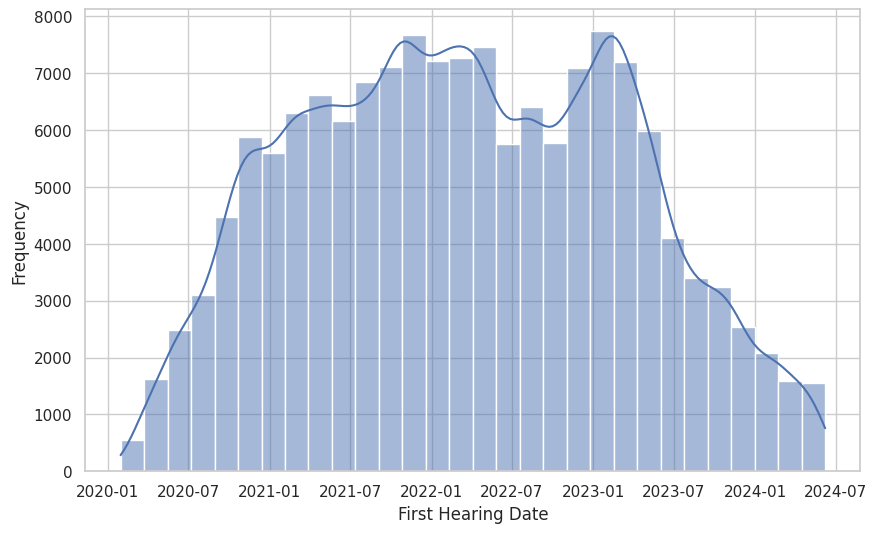

In [446]:
plot_hist(df_train, 'First Hearing Date')

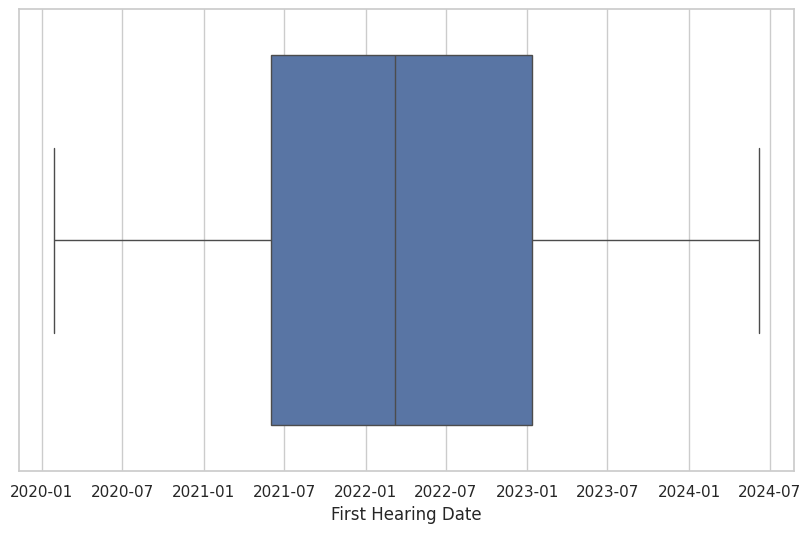

In [447]:
plot_box(df_train, 'First Hearing Date')

- Observations
  - High amount of missing values that will be treated by the imputer.
- Decisions
  - None

### Age at injury variable

Let's examine the key statistics for this variable:

In [448]:
df_train['Age at Injury'].describe()

,Age at Injury
count,574026.000000
mean,42.114270
std,14.256432
min,0.000000
25%,31.000000
50%,42.000000
75%,54.000000
max,117.000000


In [449]:
print('The Age at Injury variable has ' + str(df_train['Age at Injury'].isna().mean()*100) + '% of missing values in the train data')
print('The Age at Injury variable has ' + str(df_test['Age at Injury'].isna().mean()*100) + '% of missing values in the test data')

The Age at Injury variable has 3.276486972404717% of missing values in the train data
The Age at Injury variable has 0.0% of missing values in the test data


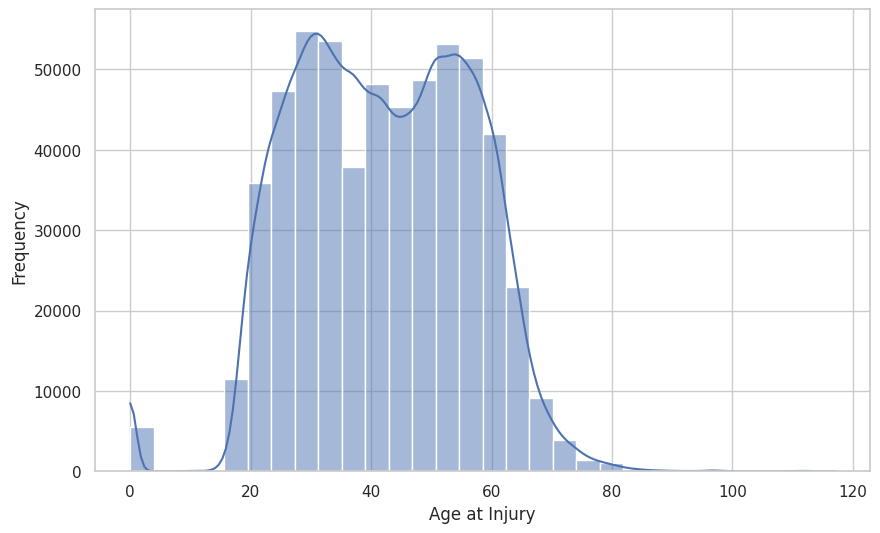

In [450]:
plot_hist(df_train, 'Age at Injury')

In [451]:
print(df_train[df_train['Age at Injury']==0]['Age at Injury'].count())
print(df_test[df_test['Age at Injury']==0]['Age at Injury'].count())

5464
3248


There is in this variable at the two dataframes null values, we will fill them with NAN values because they are probably due to some data coleting problem.

Another issue is the presence of incorrect values in this variable. Specifically, ages below 14 are invalid, as the minimum working age in the U.S. is 14 years. Additionally, ages exceeding 80 are also considered erroneous.

In [453]:
print(df_train[(df_train['Age at Injury'] < 14) | (df_train['Age at Injury'] > 80)]['Age at Injury'].count())
print(df_test[(df_test['Age at Injury'] < 14) | (df_test['Age at Injury'] > 80)]['Age at Injury'].count())

838
900


As there is a small number of rows with this problem, we will just eliminate them (only in train data)

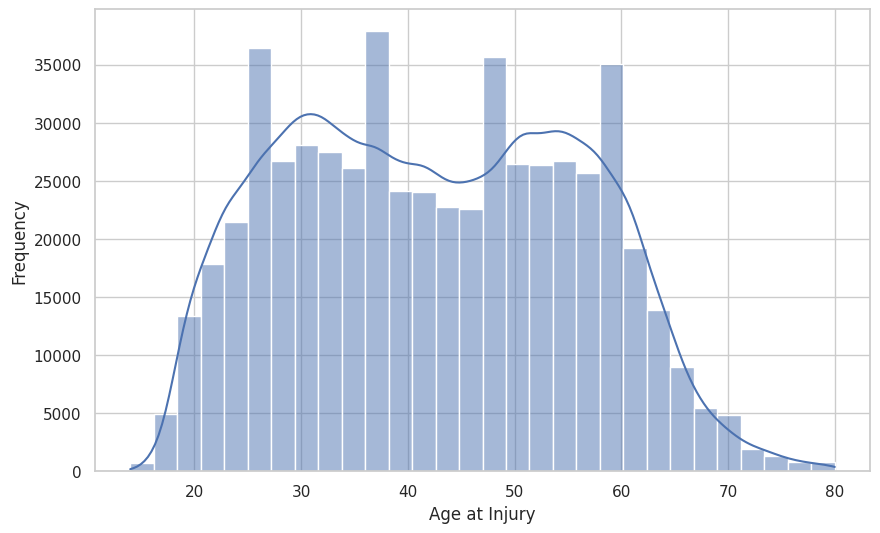

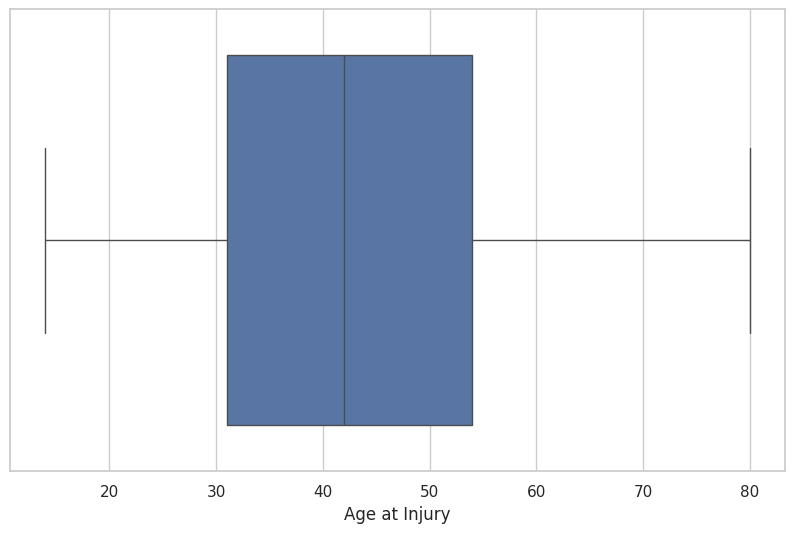

In [455]:
plot_hist(df_train, 'Age at Injury')
plot_box(df_train, 'Age at Injury')

- Observations
  - No outliers.
  - Lots of 0 values
  - Ages below 14 or above 80 exist.
- Decisions
  - We want to replace 0 with NaN for them to be imputed
  - We regard ages below 14 or above 80 as erroneous, therefore dropping any rows where this is the case from the training data. We consider the probability of these rows being full with false data high, therefore our model should not be trained on those.

### Birth Year variable

Let's examine the key statistics for this variable:

In [456]:
df_train['Birth Year'].describe()

,Birth Year
count,544152.000000
mean,1886.886940
std,414.517136
min,0.000000
25%,1965.000000
50%,1977.000000
75%,1989.000000
max,2008.000000


There are Birth years with a value of 0, this is clearly an error so we will replace it with a missing value

In [457]:
df_train[df_train['Birth Year']==0]['Birth Year'].count()

25027

In [459]:
print('The Birth Year variable has ' + str(df_train['Birth Year'].isna().mean()*100) + '% of missing values in the train data')
print('The Birth Year variable has ' + str(df_test['Birth Year'].isna().mean()*100) + '% of missing values in the test data')

The Birth Year variable has 12.403629227532049% of missing values in the train data
The Birth Year variable has 10.06920549004446% of missing values in the test data


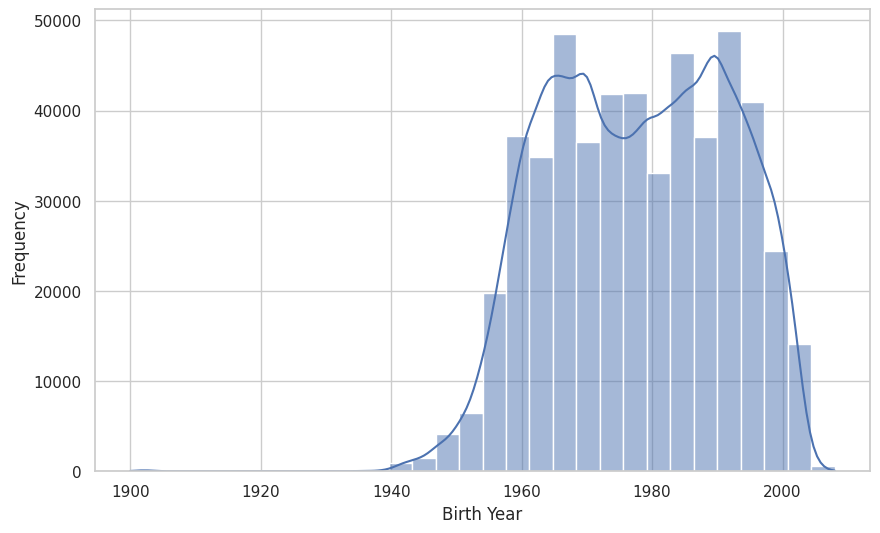

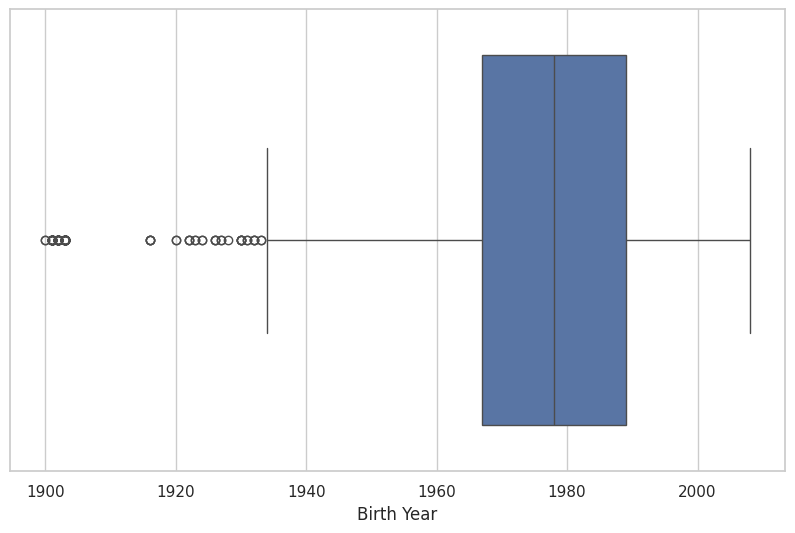

In [460]:
plot_hist(df_train, 'Birth Year')
plot_box(df_train, 'Birth Year')


- Observations
  - Some outliers, not extreme.
- Decisions
  - Replace 0 with NaN



### Carrier Type variable

Let's examine the key statistics for this variable:

In [461]:
df_train['Carrier Type'].describe()

,Carrier Type
count,573188
unique,8
top,1A. PRIVATE
freq,284862


In [462]:
df_train['Carrier Type'].value_counts()

,count
Carrier Type,
1A. PRIVATE,284862
3A. SELF PUBLIC,121759
2A. SIF,111025
4A. SELF PRIVATE,52736
UNKNOWN,1774
5D. SPECIAL FUND - UNKNOWN,1023
5C. SPECIAL FUND - POI CARRIER WCB MENANDS,5
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A),4


In [463]:
print('The Carrier Type variable has ' + str(df_train['Carrier Type'].isna().mean()*100) + '% of missing values in the train data')
print('The Carrier Type variable has ' + str(df_test['Carrier Type'].isna().mean()*100) + '% of missing values in the test data')

The Carrier Type variable has 3.2811200186287297% of missing values in the train data
The Carrier Type variable has 0.0% of missing values in the test data


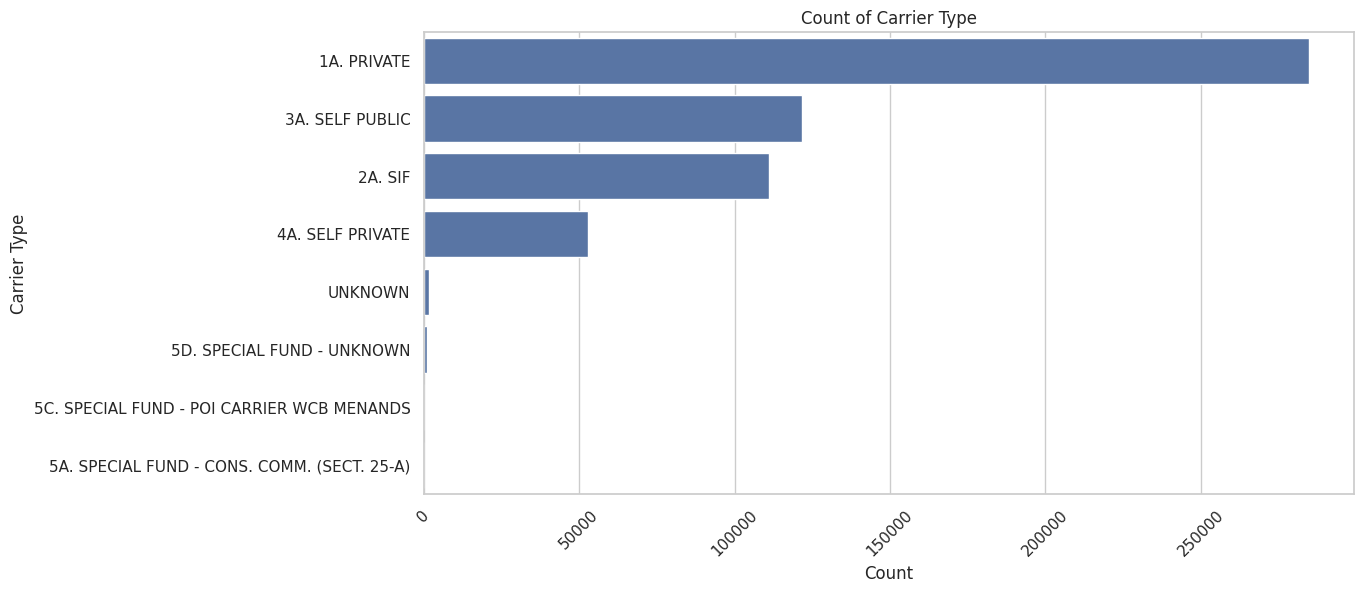

In [464]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a count plot for 'District Name'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='Carrier Type', order=df_train['Carrier Type'].value_counts().index)
plt.title('Count of Carrier Type')
plt.xlabel('Count')
plt.ylabel('Carrier Type')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

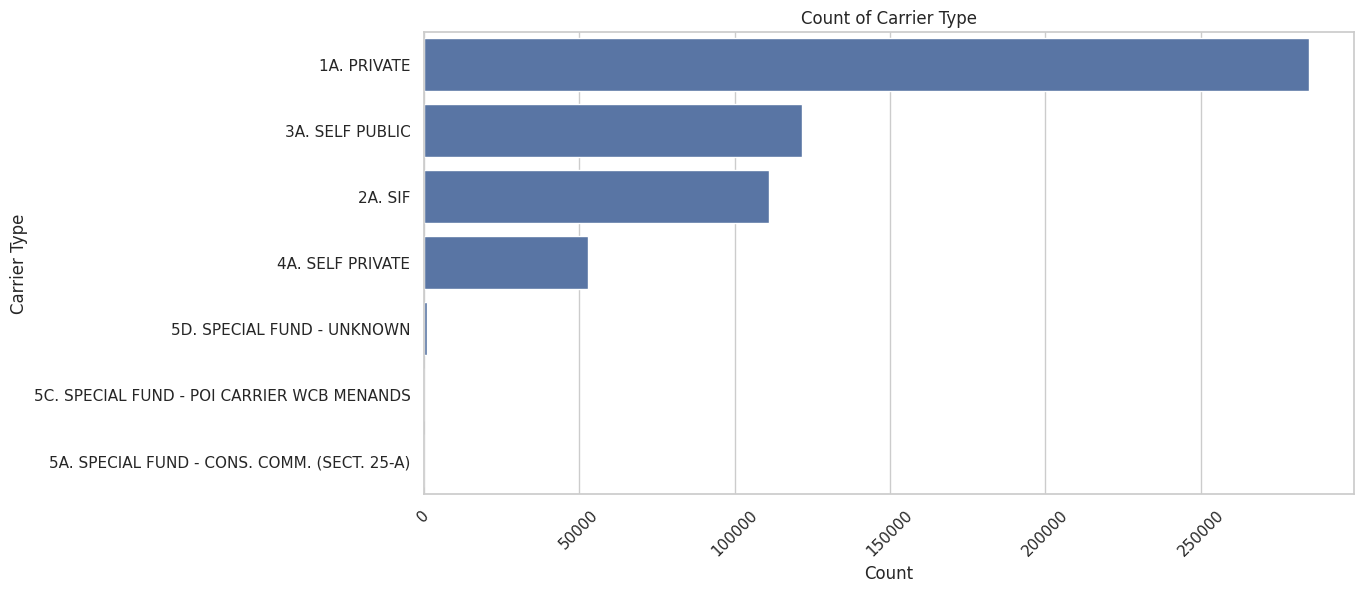

In [466]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a count plot for 'District Name'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='Carrier Type', order=df_train['Carrier Type'].value_counts().index)
plt.title('Count of Carrier Type')
plt.xlabel('Count')
plt.ylabel('Carrier Type')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

- Observations
  -
- Decisions
  - Replace unknown with NaN

### County of Injury variable

Let's examine the key statistics for this variable:

In [467]:
df_train['County of Injury'].describe()

,County of Injury
count,573188
unique,63
top,SUFFOLK
freq,60322


In [468]:
df_train['County of Injury'].unique()

array(['ST. LAWRENCE', 'WYOMING', 'ORANGE', nan, 'DUTCHESS', 'SUFFOLK',
       'ONONDAGA', 'RICHMOND', 'MONROE', 'KINGS', 'NEW YORK', 'QUEENS',
       'WESTCHESTER', 'GREENE', 'NASSAU', 'ALBANY', 'ERIE', 'BRONX',
       'CAYUGA', 'NIAGARA', 'LIVINGSTON', 'WASHINGTON', 'MADISON',
       'WARREN', 'SENECA', 'GENESEE', 'SARATOGA', 'CHAUTAUQUA',
       'COLUMBIA', 'RENSSELAER', 'CATTARAUGUS', 'ROCKLAND', 'SCHUYLER',
       'BROOME', 'ULSTER', 'CLINTON', 'ONEIDA', 'UNKNOWN', 'MONTGOMERY',
       'ONTARIO', 'SCHENECTADY', 'CHEMUNG', 'YATES', 'HERKIMER',
       'ALLEGANY', 'TIOGA', 'FULTON', 'DELAWARE', 'TOMPKINS', 'PUTNAM',
       'OSWEGO', 'LEWIS', 'ESSEX', 'OTSEGO', 'CORTLAND', 'ORLEANS',
       'SULLIVAN', 'CHENANGO', 'FRANKLIN', 'WAYNE', 'JEFFERSON',
       'STEUBEN', 'SCHOHARIE', 'HAMILTON'], dtype=object)

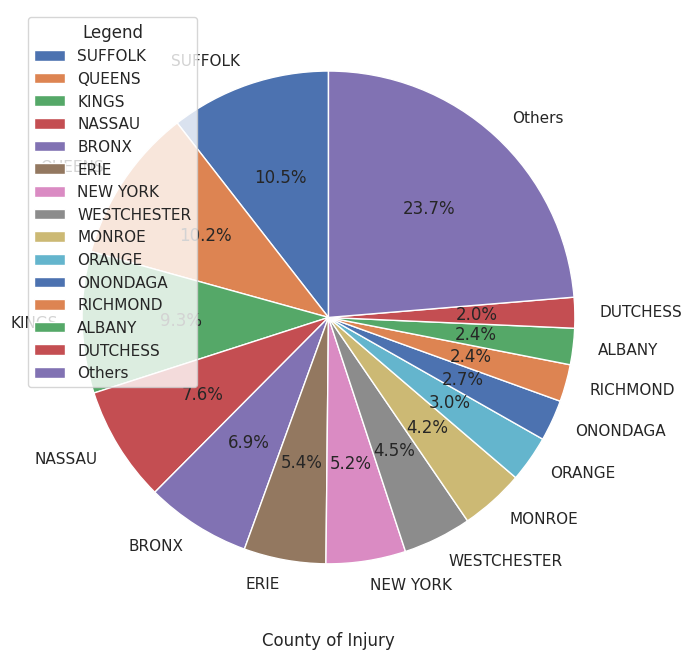

In [469]:
plot_pie(df_train, 'County of Injury')

In [470]:
print('The County of Injury variable has ' + str(df_train['County of Injury'].isna().mean()*100) + '% of missing values in the train data')
print('The County of Injury variable has ' + str(df_test['County of Injury'].isna().mean()*100) + '% of missing values in the test data')

The County of Injury variable has 3.2811200186287297% of missing values in the train data
The County of Injury variable has 0.0% of missing values in the test data


- Observations
  - No unknown/others
- Decisions
  - No actions

### Attorney Representation variable

Let's examine the key statistics for this variable:

In [471]:
df_train['Attorney/Representative'].describe()

,Attorney/Representative
count,573188
unique,2
top,N
freq,391620


In [472]:
df_train['Attorney/Representative'].value_counts()

,count
Attorney/Representative,
N,391620
Y,181568


In [473]:
print('The Attorney/Representative variable has ' + str(df_train['Attorney/Representative'].isna().mean()*100) + '% of missing values in the train data')
print('The Attorney/Representative variable has ' + str(df_test['Attorney/Representative'].isna().mean()*100) + '% of missing values in the test data')

The Attorney/Representative variable has 3.2811200186287297% of missing values in the train data
The Attorney/Representative variable has 0.0% of missing values in the test data


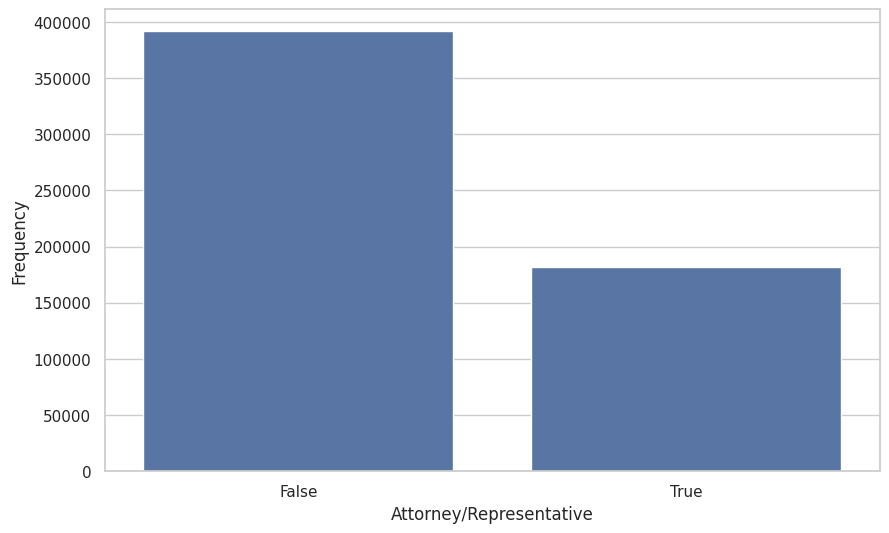

In [476]:
plot_bar(df_train, 'Attorney/Representative')

- Observations
  - No unknown labels
- Decisions
  - Change feature type to boolean

### Alternative Dispute Resolution variable

Let's examine the key statistics for this variable:

In [477]:
df_train['Alternative Dispute Resolution'].describe()

,Alternative Dispute Resolution
count,573188
unique,3
top,N
freq,570575


In [481]:
print('The Alternative Dispute Resolution variable has ' + str(df_train['Alternative Dispute Resolution'].isna().mean()*100) + '% of missing values in the train data')
print('The Alternative Dispute Resolution variable has ' + str(df_test['Alternative Dispute Resolution'].isna().mean()*100) + '% of missing values in the test data')

The Alternative Dispute Resolution variable has 3.2819637110994497% of missing values in the train data
The Alternative Dispute Resolution variable has 0.0002577485662736001% of missing values in the test data


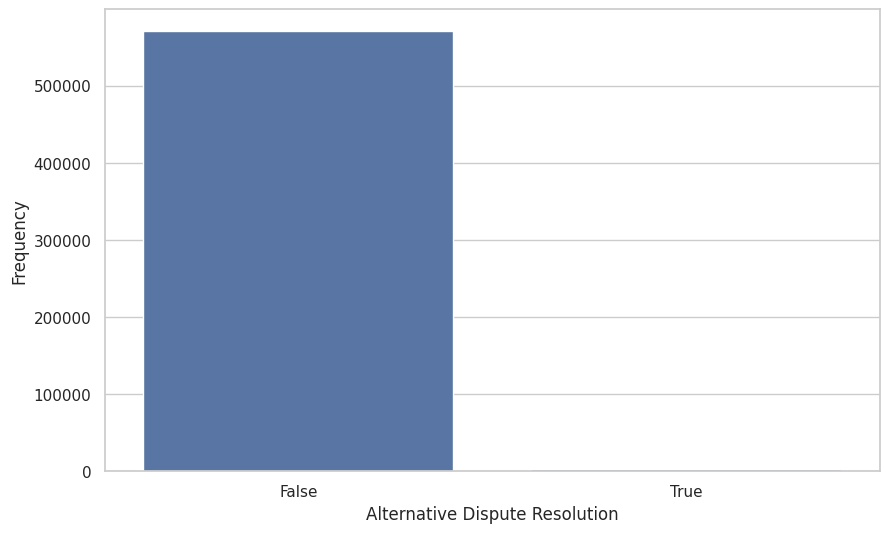

In [482]:
plot_bar(df_train, 'Alternative Dispute Resolution')

- Observations
  - Very asymetric - most are False
  - Unknown label "U"
- Decisions
  - Unknown label "U" to NaN

### Carrier Name variable

Let's examine the key statistics for this variable:

In [483]:
df_train['Carrier Name'].describe()

,Carrier Name
count,573188
unique,2043
top,STATE INSURANCE FUND
freq,111025


In [484]:
print('The Carrier Name variable has ' + str(df_train['Carrier Name'].isna().mean()*100) + '% of missing values in the train data')
print('The Carrier Name variable has ' + str(df_test['Carrier Name'].isna().mean()*100) + '% of missing values in the test data')

The Carrier Name variable has 3.2811200186287297% of missing values in the train data
The Carrier Name variable has 0.0% of missing values in the test data


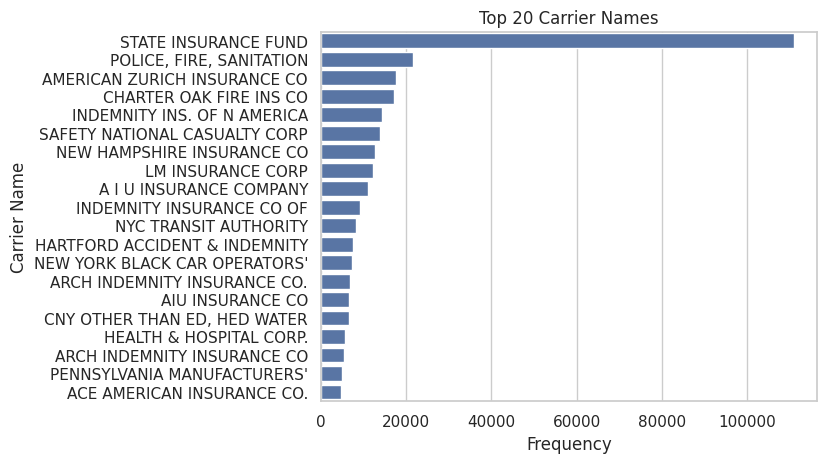

In [485]:
top_carriers = df_train['Carrier Name'].value_counts().nlargest(20)
sns.barplot(x=top_carriers.values, y=top_carriers.index)
plt.title('Top 20 Carrier Names')
plt.xlabel('Frequency')
plt.ylabel('Carrier Name')
plt.show()

In [486]:
df_train['Carrier Name'].unique().shape

(2044,)

In [487]:
df_train['Carrier Name'][df_train['Carrier Name'].str.contains("unknown", case=False, na=False)].unique()

array([], dtype=object)

- Observations
  - A lot of labels (2000+)
  - No unknown labels
- Decisions
  - TODO: Replace unknown carriers with "OTHERS"?

### Claim Identifier variable

Let's examine the key statistics for this variable:

In [488]:
df_train['Claim Identifier'].describe()

,Claim Identifier
count,5.926330e+05
mean,2.369283e+07
std,1.080013e+08
min,5.393066e+06
25%,5.593395e+06
50%,5.791106e+06
75%,5.990912e+06
max,9.998917e+08


In [489]:
df_train['Claim Identifier'].nunique()

592632

In [490]:
df_train['Claim Identifier'].size

592633

In [491]:
print('The Claim Identifier variable has ' + str(df_train['Claim Identifier'].isna().mean()*100) + '% of missing values in the train data')
print('The Claim Identifier variable has ' + str(df_test['Claim Identifier'].isna().mean()*100) + '% of missing values in the test data')

The Claim Identifier variable has 0.0% of missing values in the train data
The Claim Identifier variable has 0.0% of missing values in the test data


In [492]:
# Check duplicate rows
df_train[df_train['Claim Identifier'].duplicated(keep=False)]

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
257901,NaT,NaN,<NA>,2021-05-21,<NA>,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526445,NaT,NaN,<NA>,2022-09-05,<NA>,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Observations
  - One duplicate identifier. Both Rows are full of NaN values upon closer inspection.
- Decisions
  - Remove all rows of this Identifier as they seem to be erroneous.

### District Name variable

In [494]:
df_train['District Name'] = df_train['District Name'].astype('category')
df_test['District Name'] = df_test['District Name'].astype('category')

Let's examine the key statistics for this variable:

In [495]:
df_train['District Name'].describe()

,District Name
count,573188
unique,8
top,NYC
freq,270412


In [496]:
print('The District Name variable has ' + str(df_train['District Name'].isna().mean()*100) + '% of missing values in the train data')
print('The District Name variable has ' + str(df_test['District Name'].isna().mean()*100) + '% of missing values in the test data')

The District Name variable has 3.280793613563921% of missing values in the train data
The District Name variable has 0.0% of missing values in the test data


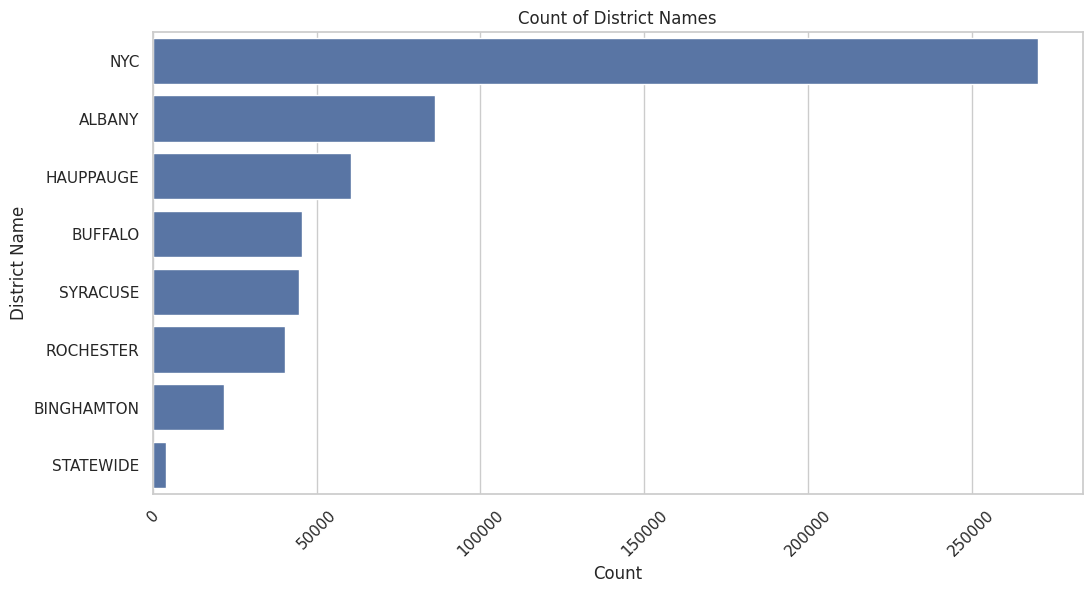

In [497]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a count plot for 'District Name'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='District Name', order=df_train['District Name'].value_counts().index)
plt.title('Count of District Names')
plt.xlabel('Count')
plt.ylabel('District Name')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

- Observations
  - No unknown values
- Decisions
  - None

### IME-4 Count variable

Let's examine the key statistics for this variable:

In [498]:
df_train['IME-4 Count'].describe()

,IME-4 Count
count,132674.000000
mean,3.207433
std,2.832536
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,73.000000


In [499]:
print('The IME-4 Count variable has ' + str(df_train['IME-4 Count'].isna().mean()*100) + '% of missing values in the train data')
print('The IME-4 Count variable has ' + str(df_test['IME-4 Count'].isna().mean()*100) + '% of missing values in the test data')

The IME-4 Count variable has 77.61271347600783% of missing values in the train data
The IME-4 Count variable has 90.91462078742187% of missing values in the test data


Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner's Report of Independent Medical Examination” form.

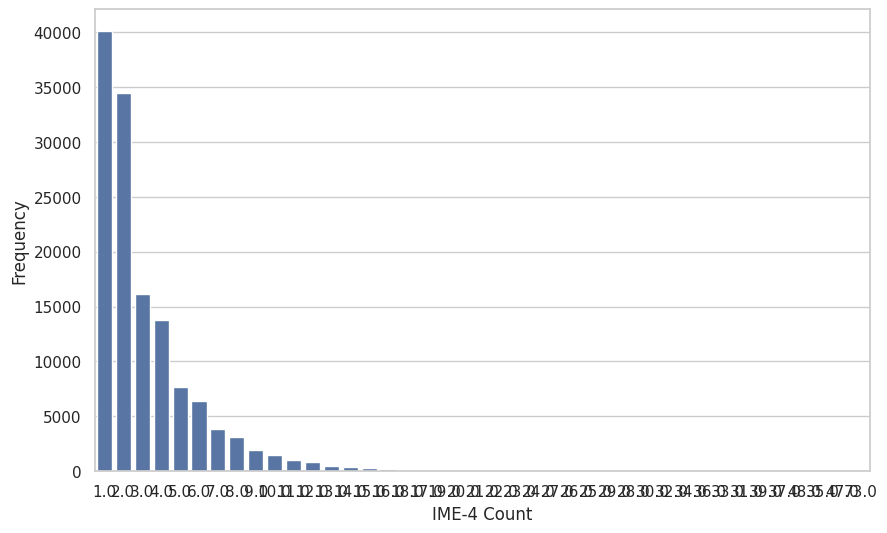

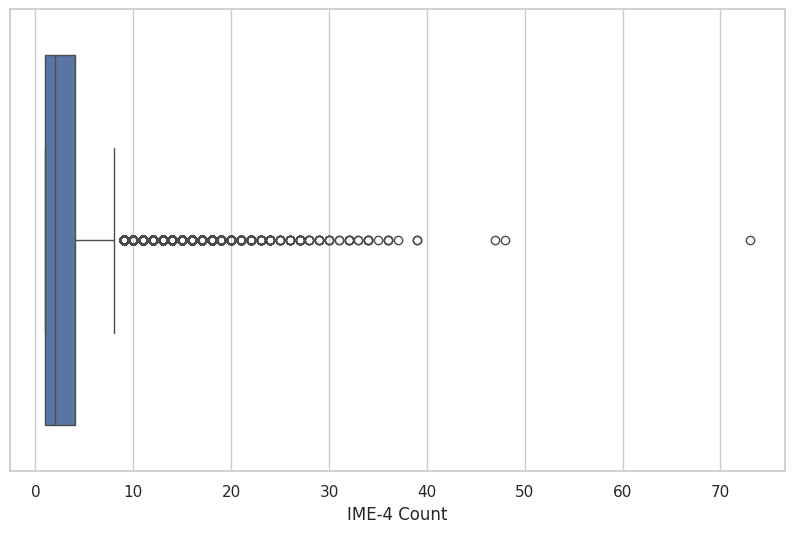

In [500]:
plot_bar(df_train, 'IME-4 Count')
plot_box(df_train, 'IME-4 Count')

Having more than 10 filled IME-4 forms per claim does raise some concerns and could indicate potential errors or unusual circumstances.

In [501]:
df_train[df_train['IME-4 Count'] > 10]['IME-4 Count'].count()

3791

In [502]:
high_submission_claims = df_train[df_train['IME-4 Count'] > 10]
high_submission_claims.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
269,2019-12-22,22.0,False,2020-01-02,True,443.40,1997.0,2020-01-02,NaT,AMERICAN ZURICH INSURANCE CO,...,74.0,"FELLOW WORKER, PATIENT OR OTHER PERSON",16.0,DISLOCATION,53.0,KNEE,11210,1.0,Not Work Related,2.0
441,2019-12-10,49.0,False,2020-01-02,True,909.39,1970.0,2020-05-29,2019-12-23,EVEREST NATIONAL INSURANCE CO.,...,45.0,COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE,52.0,STRAIN OR TEAR,90.0,MULTIPLE BODY PARTS (INCLUDING BODY,11208,0.0,Not Work Related,1.0
452,2019-12-20,50.0,False,2020-01-02,True,1383.50,NaN,2020-01-02,NaT,MANUFACTURERS ALLIANCE,...,56.0,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,12419,1.0,Not Work Related,0.0
460,2019-12-31,56.0,False,2020-01-02,True,900.20,1964.0,2020-01-02,NaT,STATE INSURANCE FUND,...,29.0,ON SAME LEVEL,28.0,FRACTURE,55.0,ANKLE,12458,0.0,Not Work Related,1.0
741,2019-12-20,39.0,False,2020-01-03,True,756.78,1980.0,2020-01-03,2020-01-24,HARTFORD ACCIDENT & INDEMNITY,...,45.0,COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,10460,0.0,Not Work Related,3.0


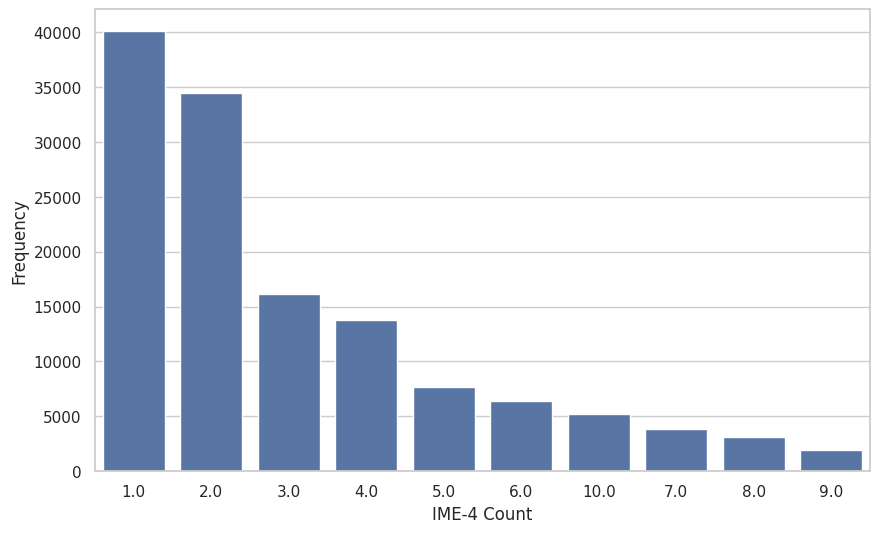

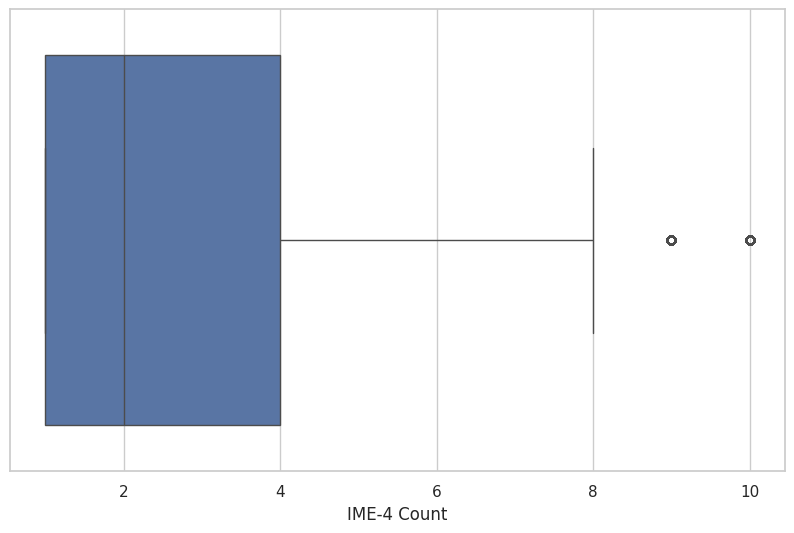

In [504]:
plot_bar(df_train, 'IME-4 Count')
plot_box(df_train, 'IME-4 Count')

- Observations
  - A lot of cases with more than 10 medical forms submitted.
- Decisions
  - Cap medical forms to 10. We consider anything from 10 to be extreme.

### Number of Dependents variable

Let's examine the key statistics for this variable:

In [505]:
df_train['Number of Dependents'].describe()

,Number of Dependents
count,573188.000000
mean,3.006481
std,2.000841
min,0.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,6.000000


In [506]:
print('The Number of Dependents variable has ' + str(df_train['Number of Dependents'].isna().mean()*100) + '% of missing values in the train data')
print('The Number of Dependents variable has ' + str(df_test['Number of Dependents'].isna().mean()*100) + '% of missing values in the test data')

The Number of Dependents variable has 3.280793613563921% of missing values in the train data
The Number of Dependents variable has 0.0% of missing values in the test data


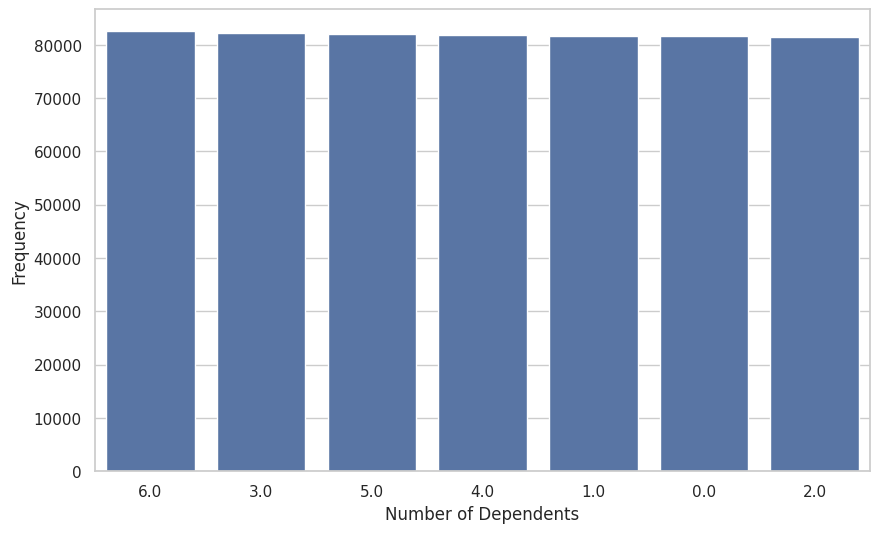

In [507]:
plot_bar(df_train, 'Number of Dependents')

### COVID-19 Indicator variable

Let's examine the key statistics for this variable:

In [508]:
df_train['COVID-19 Indicator'].describe()

,COVID-19 Indicator
count,573188
unique,2
top,N
freq,545694


In [509]:
df_train['COVID-19 Indicator'].value_counts()

,count
COVID-19 Indicator,
N,545694
Y,27494


In [510]:
print('The COVID-19 Indicator variable has ' + str(df_train['COVID-19 Indicator'].isna().mean()*100) + '% of missing values in the train data')
print('The COVID-19 Indicator variable has ' + str(df_test['COVID-19 Indicator'].isna().mean()*100) + '% of missing values in the test data')

The COVID-19 Indicator variable has 3.280793613563921% of missing values in the train data
The COVID-19 Indicator variable has 0.0% of missing values in the test data


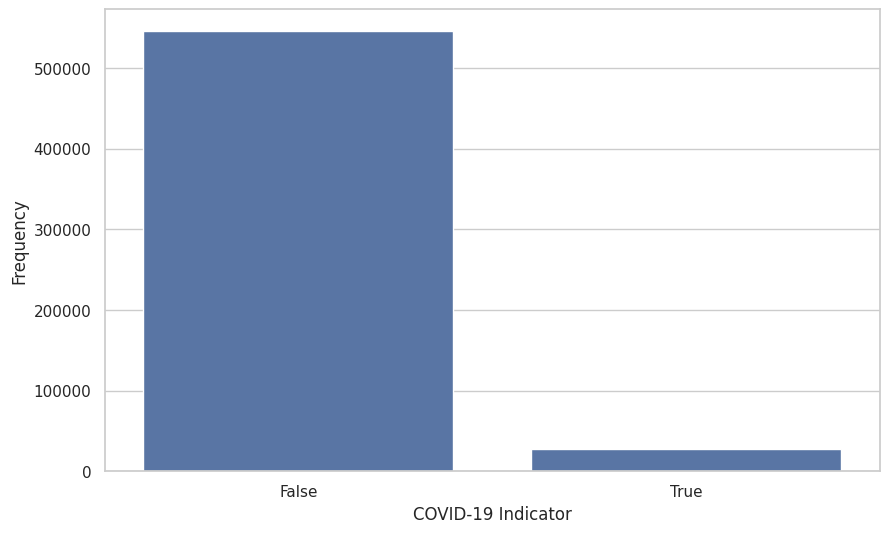

In [512]:
plot_bar(df_train, 'COVID-19 Indicator')

- Observations
  - No unknown values.
- Decisions
  - Transform to boolean

### Average Weekly Wage variable

Let's examine the key statistics for this variable:

In [513]:
df_train['Average Weekly Wage'].describe()

,Average Weekly Wage
count,5.445700e+05
mean,4.914745e+02
std,6.097209e+03
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,8.420175e+02
max,2.828079e+06


In [514]:
(df_train['Average Weekly Wage'] == 0).sum()

334867

It is not possible to have values in 'Average Weekly Wage' recorded as zero since we are talking about workers. Since there are 333933 values recorded as zero, it is very unlikely that this is an error. We replace the zeros with NaN values.

In [515]:
df_train['Average Weekly Wage'] = df_train['Average Weekly Wage'].replace(0, np.nan)

In [516]:
(df_train['Average Weekly Wage'].isna().mean())*100


64.61491214600655

More than 60% of the Average Weekly Wage column has unknown information. This gonna produce issues in analysis and modeling. Replacing those missing values with statistical measures like the mean or median can skew results and introduce bias, especially if the data is not missing at random. Using methods like KNN can also lead to unreliable estimates if the underlying distribution is not well understood.


Given these circumstances, removing the column might be the most prudent approach.


Let's explore the variable anyway

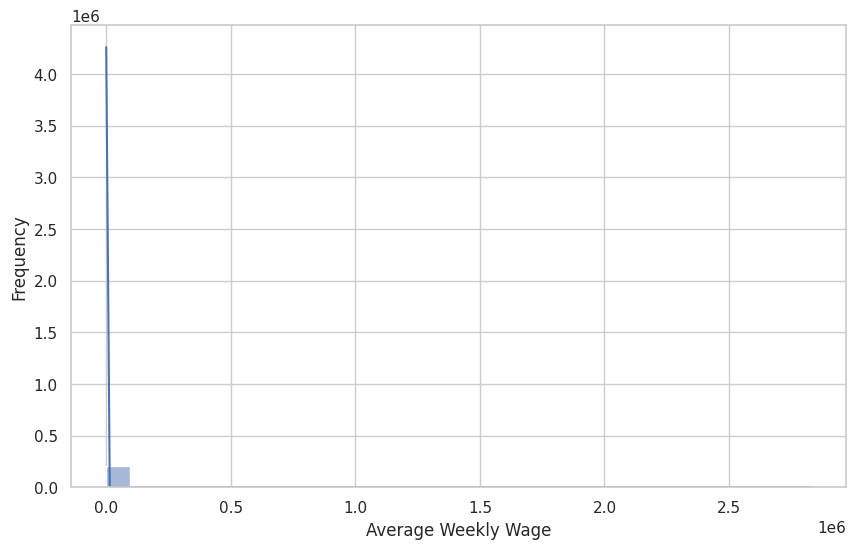

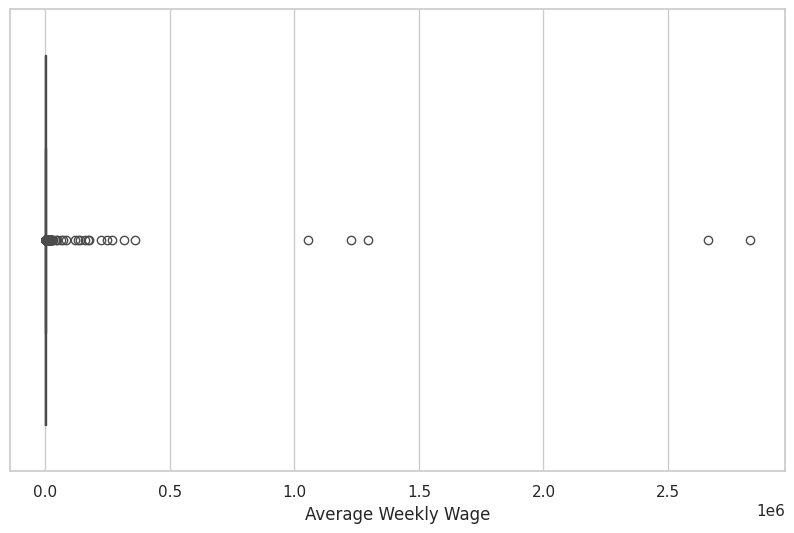

In [517]:
plot_hist(df_train, 'Average Weekly Wage')
plot_box(df_train, 'Average Weekly Wage')

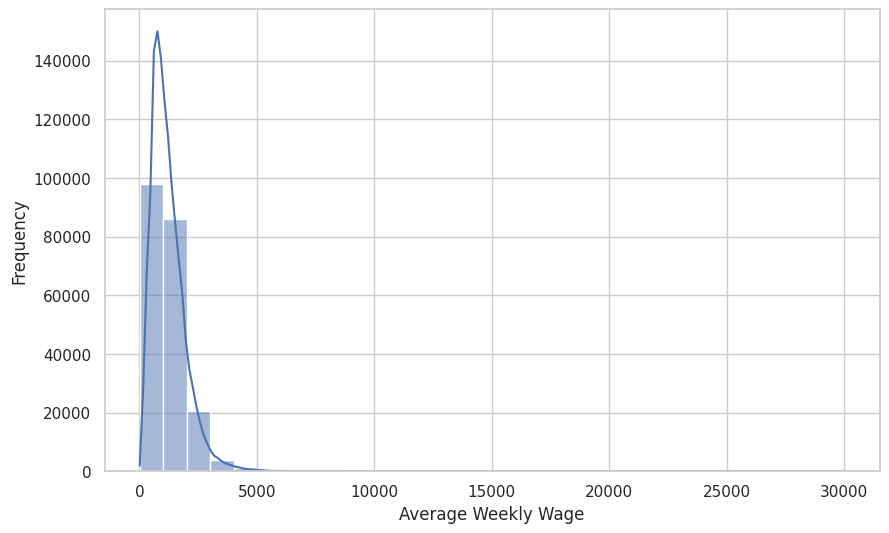

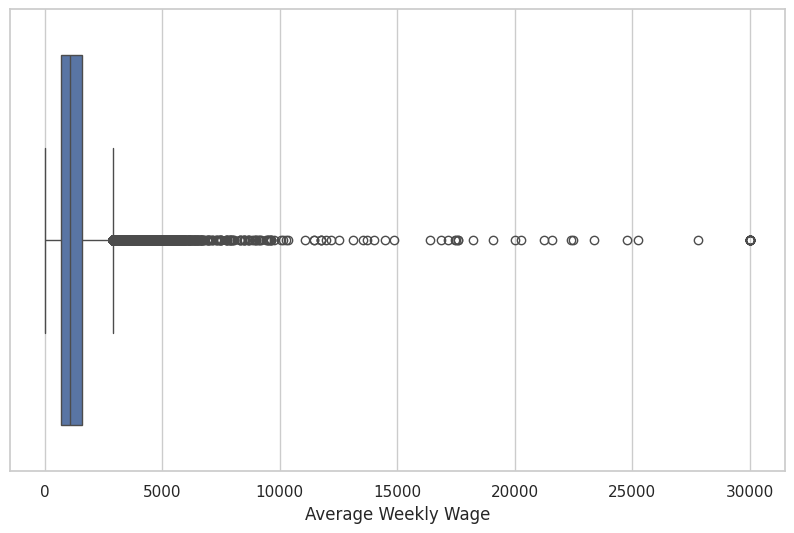

In [522]:
plot_hist(df_train, 'Average Weekly Wage')
plot_box(df_train, 'Average Weekly Wage')

- Observations
  - A lot of high outliers.
- Decisions
  - Cap extreme outliers (anything above 30k weekly income is counted as extreme).

### Industry code and Industry code description variable

Let's examine the key statistics for this variable:

In [524]:
df_train['Industry Code'].describe()

,Industry Code
count,563236.0
unique,24.0
top,62.0
freq,114249.0


In [525]:
df_train['Industry Code'].value_counts()

,count
Industry Code,
62.0,114249
92.0,92136
61.0,44307
44.0,43606
48.0,37283
23.0,30889
72.0,26377
56.0,21005
45.0,17887


In [526]:
print('The Industry Code variable has ' + str(df_train['Industry Code'].isna().mean()*100) + '% of missing values in the train data')
print('The Industry Code variable has ' + str(df_test['Industry Code'].isna().mean()*100) + '% of missing values in the test data')

The Industry Code variable has 4.960084774505552% of missing values in the train data
The Industry Code variable has 1.9939429086925704% of missing values in the test data


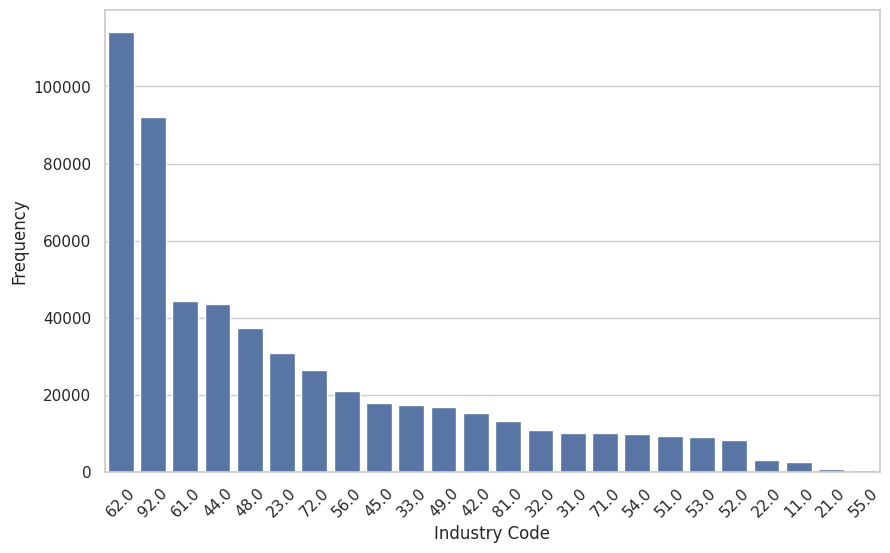

In [527]:
plot_bar(df_train, 'Industry Code',degrees=45)

- Observations
  - No unknown values/categories
- Decisions
  - None

### Medical Fee Region variable

Let's examine the key statistics for this variable:

In [528]:
df_train['Medical Fee Region'].describe()

,Medical Fee Region
count,573188
unique,5
top,IV
freq,265621


In [529]:
df_train['Medical Fee Region'].value_counts()

,count
Medical Fee Region,
IV,265621
I,135649
II,84935
III,53560
UK,33423


In [530]:
print('The Medical Fee Region variable has ' + str(df_train['Medical Fee Region'].isna().mean()*100) + '% of missing values in the train data')
print('The Medical Fee Region variable has ' + str(df_test['Medical Fee Region'].isna().mean()*100) + '% of missing values in the test data')

The Medical Fee Region variable has 3.280793613563921% of missing values in the train data
The Medical Fee Region variable has 0.0% of missing values in the test data


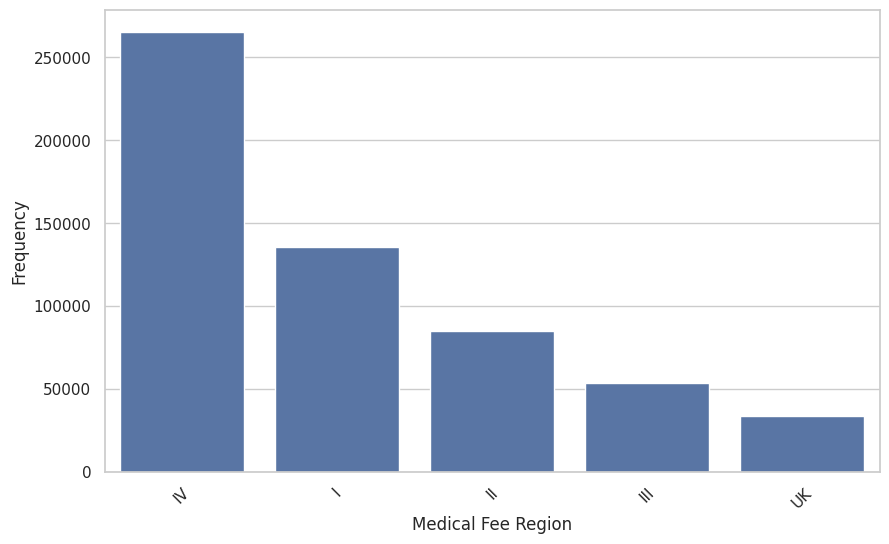

In [531]:
plot_bar(df_train, 'Medical Fee Region',degrees=45)

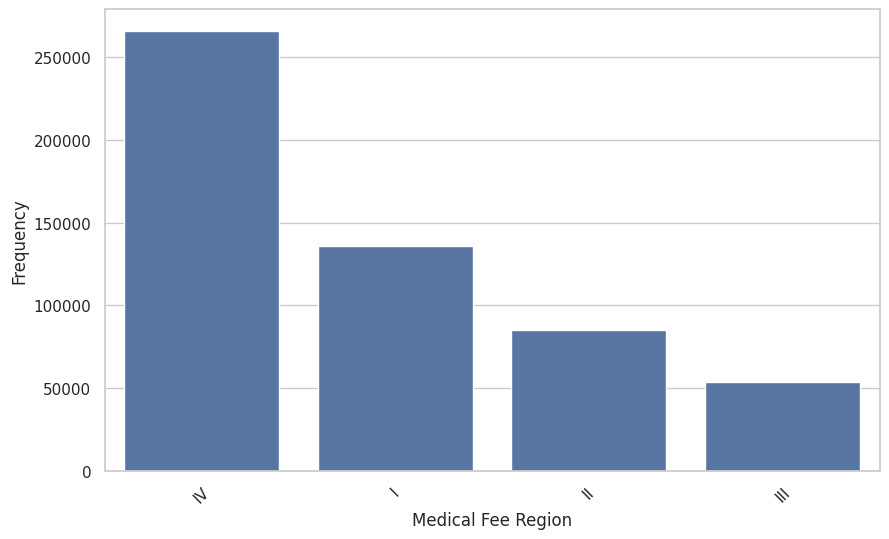

In [535]:
plot_bar(df_train, 'Medical Fee Region',degrees=45)

- Observations
  - "UK" treated as unknown values.
- Decisions
  - "UK" values as NaN

### WCIO Cause of Injury Code and WCIO Cause of Injury Description variables

Let's examine the key statistics for this variable:

In [536]:
df_train['WCIO Cause of Injury Code'].describe()

,WCIO Cause of Injury Code
count,557562.0
unique,77.0
top,56.0
freq,46582.0


In [537]:
df_train['WCIO Cause of Injury Description'].describe()

,WCIO Cause of Injury Description
count,557562
unique,74
top,LIFTING
freq,46582


In [538]:
df_train['WCIO Cause of Injury Code'].value_counts()

,count
WCIO Cause of Injury Code,
56.0,46582
74.0,37129
60.0,33164
31.0,31618
29.0,29244
...,...
91.0,55
14.0,51
40.0,45


In [539]:
df_train['WCIO Cause of Injury Description'].value_counts()

,count
WCIO Cause of Injury Description,
LIFTING,46582
"FELLOW WORKER, PATIENT OR OTHER PERSON",37129
"STRAIN OR INJURY BY, NOC",33164
"FALL, SLIP OR TRIP, NOC",31618
ON SAME LEVEL,29244
...,...
MOLD,55
ABNORMAL AIR PRESSURE,51
CRASH OF WATER VEHICLE,45


In [540]:
print('The WCIO Cause of Injury Code variable has ' + str(df_train['WCIO Cause of Injury Code'].isna().mean()*100) + '% of missing values in the train data')
print('The WCIO Cause of Injury Code variable has ' + str(df_test['WCIO Cause of Injury Code'].isna().mean()*100) + '% of missing values in the test data')

The WCIO Cause of Injury Code variable has 5.917510221368778% of missing values in the train data
The WCIO Cause of Injury Code variable has 2.667182163799214% of missing values in the test data


In [541]:
print('The WCIO Cause of Injury Description variable has ' + str(df_train['WCIO Cause of Injury Description'].isna().mean()*100) + '% of missing values in the train data')
print('The WCIO Cause of Injury Description variable has ' + str(df_test['WCIO Cause of Injury Description'].isna().mean()*100) + '% of missing values in the test data')

The WCIO Cause of Injury Description variable has 5.917510221368778% of missing values in the train data
The WCIO Cause of Injury Description variable has 2.667182163799214% of missing values in the test data


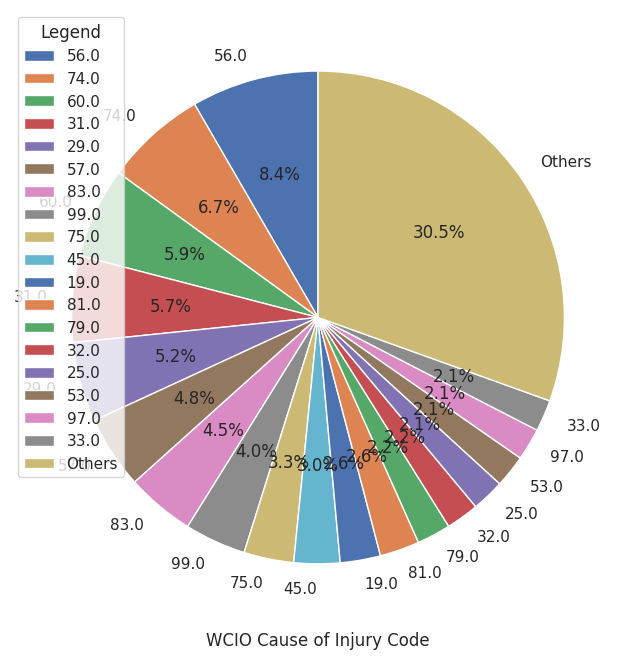

In [542]:
plot_pie(df_train, 'WCIO Cause of Injury Code')

In [544]:
# Same Description codes
print(df_train[df_train['WCIO Cause of Injury Description']=='OBJECT BEING LIFTED OR HANDLED']['WCIO Cause of Injury Code'].unique())
print(df_train[df_train['WCIO Cause of Injury Description']=='REPETITIVE MOTION']['WCIO Cause of Injury Code'].unique())

[79.0, 17.0, 66.0]
Categories (77, float64): [1.0, 2.0, 3.0, 4.0, ..., 96.0, 97.0, 98.0, 99.0]
[97.0, 94.0]
Categories (77, float64): [1.0, 2.0, 3.0, 4.0, ..., 96.0, 97.0, 98.0, 99.0]


In [545]:
df_train['WCIO Cause of Injury Description'][df_train['WCIO Cause of Injury Description'].str.contains("unknown", case=False, na=False)].unique()

array([], dtype=object)

- Observations
  - We observed multiple codes having the same description. Upon further investigation with the definition of the codes (https://www.guarantysupport.com/wp-content/uploads/2024/02/WCIO-Legacy.pdf), the code descriptions are not complete in the dataset and are truly different. No action will be taken on these same descriptions.
  - No unknown values
- Decisions
  - None

### WCIO Part of Body Code and WCIO Part of Body Description variables

Let's examine the key statistics for this variable:

In [546]:
df_train.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents'],
      dtype='object')

In [547]:
df_train['WCIO Part Of Body Code'].describe()

,WCIO Part Of Body Code
count,556116.0
unique,57.0
top,42.0
freq,51830.0


In [548]:
df_train['WCIO Part Of Body Description'].describe()

,WCIO Part Of Body Description
count,556116
unique,54
top,LOWER BACK AREA
freq,51830


In [549]:
df_train['WCIO Part Of Body Code'].value_counts()

,count
WCIO Part Of Body Code,
42.0,51830
53.0,47848
-9.0,41960
38.0,37778
36.0,36054
35.0,31354
55.0,24909
90.0,22566
56.0,18751


In [550]:
df_train['WCIO Part Of Body Description'].value_counts()

,count
WCIO Part Of Body Description,
LOWER BACK AREA,51830
KNEE,47848
MULTIPLE,41960
SHOULDER(S),37778
FINGER(S),36054
HAND,31354
ANKLE,24909
MULTIPLE BODY PARTS (INCLUDING BODY,22566
SOFT TISSUE,19654


In [551]:
print('The WCIO Part Of Body Code variable has ' + str(df_train['WCIO Part Of Body Code'].isna().mean()*100) + '% of missing values in the train data')
print('The WCIO Part Of Body Code variable has ' + str(df_test['WCIO Part Of Body Code'].isna().mean()*100) + '% of missing values in the test data')

The WCIO Part Of Body Code variable has 6.161506907333568% of missing values in the train data
The WCIO Part Of Body Code variable has 2.4612410593466074% of missing values in the test data


In [552]:
print('The WCIO Part Of Body Description variable has ' + str(df_train['WCIO Part Of Body Description'].isna().mean()*100) + '% of missing values in the train data')
print('The WCIO Part Of Body Description variable has ' + str(df_test['WCIO Part Of Body Description'].isna().mean()*100) + '% of missing values in the test data')

The WCIO Part Of Body Description variable has 6.161506907333568% of missing values in the train data
The WCIO Part Of Body Description variable has 2.4612410593466074% of missing values in the test data


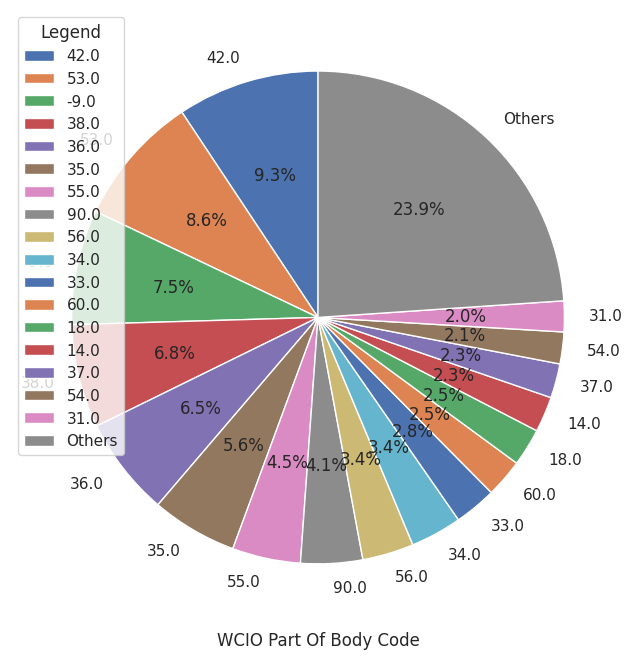

In [553]:
plot_pie(df_train, 'WCIO Part Of Body Code')

- Observations
  - Negative codes
- Decisions
  - Make negative code positive
  - Minus code for "-9.0", change to 9.0.

### ZIP Code variable

Let's examine the key statistics for this variable:

In [556]:
df_train['Zip Code'].describe()

,Zip Code
count,544590
unique,10045
top,11236
freq,3299


In [557]:
df_train['Zip Code'].value_counts()

,count
Zip Code,
11236,3299
10940,2967
11717,2802
11434,2753
11706,2725
...,...
23605,1
28092,1
80033,1


In [558]:
print('The Zip Code variable has ' + str(df_train['Zip Code'].isna().mean()*100) + '% of missing values in the train data')
print('The Zip Code variable has ' + str(df_test['Zip Code'].isna().mean()*100) + '% of missing values in the test data')

The Zip Code variable has 8.10639335438072% of missing values in the train data
The Zip Code variable has 4.985372768863973% of missing values in the test data


In [559]:
zip_code_counts = df_train.copy()

In [560]:
zip_code_temp = df_train["Zip Code"].dropna().astype(str)

1. Check for Negative Values

In [561]:
negative_values = zip_code_temp[zip_code_temp.str.startswith('-')]
if not negative_values.empty:
    print("Negative values found in 'Zip Code':")
    display(negative_values)

2. Check for Non-Numeric Characters


In [562]:
non_numeric = zip_code_temp[~zip_code_temp.str.match(r'^\d+$')]
if not non_numeric.empty:
    print("Non-numeric values found in 'Zip Code':")
    display(non_numeric)

Non-numeric values found in 'Zip Code':


,Zip Code
4585,L1N 5
9359,T1B0P
9751,L6Y 1
13688,JMDMR
15048,N2P 1
...,...
576577,V1M2B
580232,L2P0A
581907,L6L 1
583384,L1A 1


3. Check for Length Inconsistencies (assuming standard 5 digits)

In [563]:
length_inconsistent = zip_code_temp[zip_code_temp.str.len() != 5]
if not length_inconsistent.empty:
    print("Inconsistent length values found in 'Zip Code':")
    display(length_inconsistent)

Inconsistent length values found in 'Zip Code':


,Zip Code
41789,T2V
111214,SLV
182452,L9W
228112,P7G
262144,10567.0
...,...
420949,K9J
429765,M5R
455762,L1G
478123,J5K


In [564]:
merged_issues = pd.concat([non_numeric, length_inconsistent]).drop_duplicates()
if not merged_issues.empty:
    print("Merged issues found in 'Zip Code':")
    display(merged_issues)
print(merged_issues.count())

Merged issues found in 'Zip Code':


,Zip Code
4585,L1N 5
9359,T1B0P
9751,L6Y 1
13688,JMDMR
15048,N2P 1
...,...
576577,V1M2B
580232,L2P0A
581907,L6L 1
592799,G9B0Y


2004


4. Check for Placeholder Values (any amount of zeros, e.g., '000', '00000')

In [565]:
placeholders = zip_code_temp[zip_code_temp.str.match(r'^0+$')]
if not placeholders.empty:
    print("Placeholder values found in 'Zip Code' (any amount of zeros):")
    display(placeholders)

Placeholder values found in 'Zip Code' (any amount of zeros):


,Zip Code
44780,00000
48863,00000
73168,00000
73843,00000
77384,00000
215545,00000
324129,00000
329697,00000
527010,00000
527275,00000


- Observations
  1. No negative values
  2. Non numerical values are OK
  3. Length inconsistent is OK
  4. Placeholder values (00..)
- Decisions
  - Make placeholders NaNs

### Claim Injury Type variable

This variable only exists in the train data

Let's examine the key statistics for this variable:

In [567]:
df_train['Claim Injury Type'].describe()

,Claim Injury Type
count,573188
unique,8
top,2. NON-COMP
freq,290572


In [568]:
df_train['Claim Injury Type'].value_counts()

,count
Claim Injury Type,
2. NON-COMP,290572
4. TEMPORARY,148340
3. MED ONLY,68828
5. PPD SCH LOSS,48243
1. CANCELLED,12452
6. PPD NSL,4202
8. DEATH,454
7. PTD,97


In [569]:
print('The Claim Injury Type variable has ' + str(df_train['Claim Injury Type'].isna().mean()*100) + '% of missing values in the train data')

The Claim Injury Type variable has 3.280793613563921% of missing values in the train data


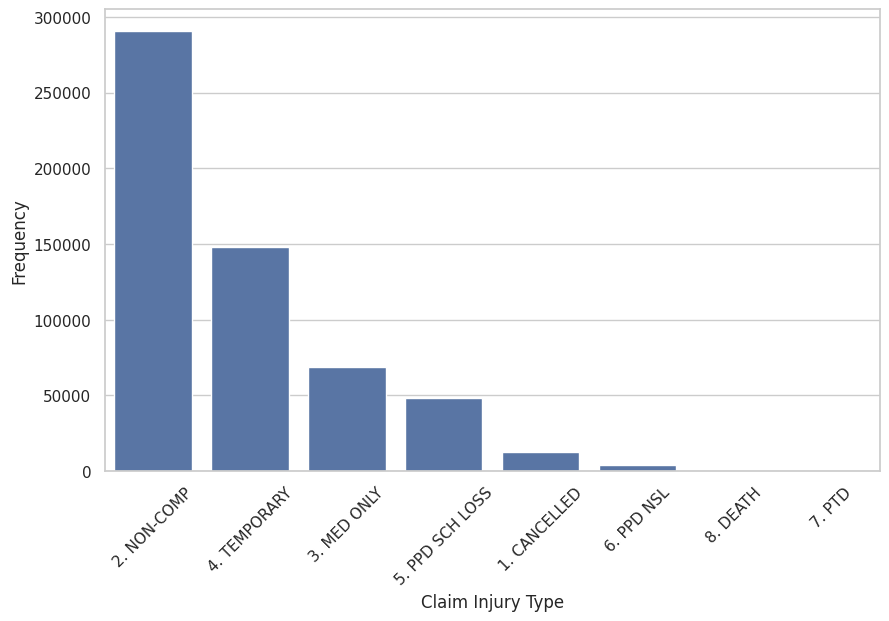

In [570]:
plot_bar(df_train, 'Claim Injury Type',degrees=45)

- Observations
  - No unknown
- Decisions
  - none

### Gender variable

Let's examine the key statistics for this variable:

In [571]:
df_train['Gender'].describe()

,Gender
count,573188
unique,4
top,M
freq,334724


In [572]:
df_train['Gender'].value_counts()

,count
Gender,
M,334724
F,233716
U,4702
X,46


In [573]:
print('The Gender variable has ' + str(df_train['Gender'].isna().mean()*100) + '% of missing values in the train data')
print('The Gender variable has ' + str(df_test['Gender'].isna().mean()*100) + '% of missing values in the test data')

The Gender variable has 3.280793613563921% of missing values in the train data
The Gender variable has 0.0% of missing values in the test data


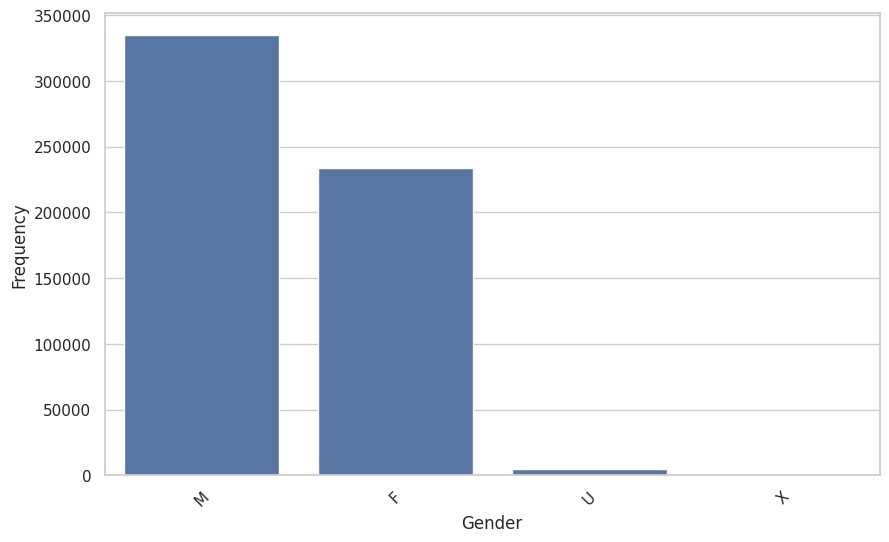

In [574]:
plot_bar(df_train, 'Gender',degrees=45)

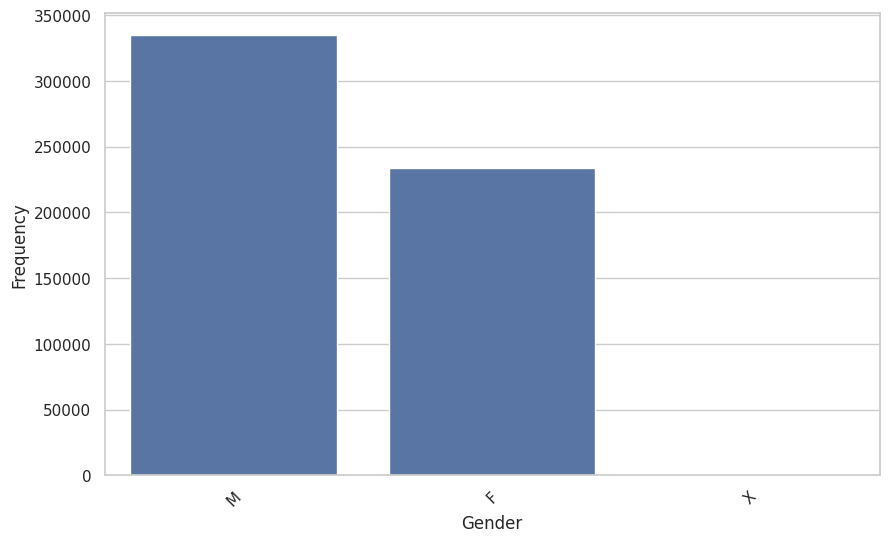

In [576]:
plot_bar(df_train, 'Gender',degrees=45)

- Observations
  - unknown values as "u"
- Decisions
  - Replace unknown with NaN

In [ ]:
# Empty columns: WCB Decision (in test), OIICS Nature of Injury Description, Agreement Reached
    # Ignore those

## Multivariate analysis

### Cross-feature inconsistencies

#### Date variables order

In [ ]:
def check_date_order(row):
    if row.isna().all():
        return True

    # Extraindo as datas das colunas relevantes
    accident_date = row['Accident Date']
    c2_date = row['C-2 Date']
    c3_date = row['C-3 Date']
    assembly_date = row['Assembly Date']
    hearing_date = row['First Hearing Date']

    # Checagem da ordem das datas
    # Se Accident Date e C-2 Date não forem NA, verificar a ordem
    if pd.notna(accident_date) and pd.notna(c2_date) and accident_date >= c2_date:
        return False

    # Se C-2 Date e C-3 Date não forem NA, verificar a ordem
    if pd.notna(c2_date) and pd.notna(c3_date) and c2_date >= c3_date:
        return False

    # Se C-3 Date e Assembly Date não forem NA, verificar a ordem
    if pd.notna(c3_date) and pd.notna(assembly_date) and c3_date >= assembly_date:
        return False

    # Se Assembly Date e First Hearing Date não forem NA, verificar a ordem
    if pd.notna(assembly_date) and pd.notna(hearing_date) and assembly_date >= hearing_date:
        return False

    return True

In [ ]:
df_train['Order Correct'] = df_train.apply(check_date_order, axis=1)

In [ ]:
df_train['Order Correct'].value_counts()

In [ ]:
df_train[df_train["Order Correct"]==False][['Claim Identifier',"Accident Date","C-2 Date","C-3 Date","Assembly Date",'First Hearing Date']]

#### Covid Code and indicator

In [ ]:
df_train.columns

In [ ]:
df_covid=df_train.copy()
df_covid = df_covid[df_covid['WCIO Nature of Injury Code'] == 83]
df_train['covid_correct']=df_covid['COVID-19 Indicator']==True
df_train['covid_correct'].value_counts()
df_train[df_train['covid_correct']==False][['WCIO Nature of Injury Code','WCIO Nature of Injury Description','COVID-19 Indicator']]

### Multivariate Visualizations

#### Visualization 1: X by Y with Z

In [1]:
#...